# ***תרגיל 5 של הפרוייקט***

**Load Data and Basic Setup**

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("/content/train-filtered_question_level.csv")

# Remove duplicate questions
df = df.drop_duplicates(subset=["question"], keep="first")

# Extract text and difficulty levels
texts = df["question"].astype(str).tolist()
levels = df["level"].tolist()


**Balancing Dataset (Undersampling to Minority Class)**

In [ ]:
# import pandas as pd

# # 1. נגדיר את גודל היעד לפי המחלקה הקטנה ביותר (Hard)
# target_size = 15657

# # 2. נבצע דגימה מכל מחלקה בנפרד
# df_hard = df[df['level'] == 'hard']
# # כאן אנחנו לא עושים sample כי זה כבר הגודל שאנחנו רוצים

# df_medium_downsampled = df[df['level'] == 'medium'].sample(n=target_size, random_state=42)
# df_easy_downsampled = df[df['level'] == 'easy'].sample(n=target_size, random_state=42)

# # 3. נחבר את שלושתן יחד
# df_balanced = pd.concat([df_hard, df_medium_downsampled, df_easy_downsampled])

# # 4. נערבב את הדאטה (חשוב מאוד!)
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# # בדיקת תוצאה
# print("התפלגות חדשה:")
# print(df_balanced['level'].value_counts())

In [2]:
import pandas as pd

# 1. הגדרת גודל המדגם לכל קטגוריה (היפר-פרמטר של שלב הניסויים)
# התחלה עם 1000 מכל אחת עוזרת לבדיקה מהירה ("מתחילים בקטן" לפי ההוראות)
target_size = 7000

# 2. דגימה מאוזנת מכל הקטגוריות בבת אחת
# groupby מבטיח שנתייחס לכל רמת קושי בנפרד
df_balanced = df.groupby('level').apply(lambda x: x.sample(n=target_size, random_state=42)).reset_index(drop=True)

# 3. ערבוב הדאטה (Shuffle) - קריטי בלמידה עמוקה!
# כדי שה-Batch לא יכיל רק מחלקה אחת בזמן האימון, מה שיהרוס את הלמידה
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# בדיקת התפלגות כפי שנדרש בשלב ה-EDA ובניתוח הדאטה
print("התפלגות חדשה ומאוזנת:")
print(df_balanced['level'].value_counts())

התפלגות חדשה ומאוזנת:
level
easy      7000
medium    7000
hard      7000
Name: count, dtype: int64


/tmp/ipython-input-4281571597.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('level').apply(lambda x: x.sample(n=target_size, random_state=42)).reset_index(drop=True)


# ***================================================================================================================================================================================================================================================***

# **תחילת עריכה חדשה**

Imports + Seed

In [4]:
!pip -q install gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 41.9 MB/s eta 0:00:00


In [21]:
import os
import re
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Word2Vec (embeddings only)
from gensim.models import Word2Vec, KeyedVectors

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

טעינת דאטה + איזון

In [22]:
df = pd.read_csv("/content/train-filtered_question_level.csv")
df = df.drop_duplicates(subset=["question"], keep="first")

target_size = 7000
df_balanced = (
    df.groupby("level")
      .apply(lambda x: x.sample(n=target_size, random_state=42))
      .reset_index(drop=True)
)

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced distribution:")
print(df_balanced["level"].value_counts())


Balanced distribution:
level
easy      7000
medium    7000
hard      7000
Name: count, dtype: int64


/tmp/ipython-input-1227022595.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=target_size, random_state=42))


Labels

In [23]:
label2id = {"easy": 0, "medium": 1, "hard": 2}
id2label = {v: k for k, v in label2id.items()}

texts = df_balanced["question"].astype(str).tolist()
y = df_balanced["level"].map(label2id).to_numpy()

NUM_CLASSES = 3
print(texts[0], "|", y[0], id2label[int(y[0])])


This is a list of NFL Draft selections by the Indianapolis Colts, the first draft that the current incarnation of the Colts franchise participated in was 1953, in which they made which gridiron football player, of Oklahoma their first ever selection? | 0 easy


Tokenize + Vocab + Encode + Pad (PyTorch-only)

In [24]:
TOKEN_RE = re.compile(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?|[^\sA-Za-z0-9]")

def tokenize(text: str):
    return TOKEN_RE.findall(str(text).lower().strip())

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

from collections import Counter

def build_vocab(texts, min_freq=2, max_vocab_size=None):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))

    vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    items = [(w, c) for w, c in counter.items() if c >= min_freq]
    items.sort(key=lambda x: (-x[1], x[0]))

    if max_vocab_size is not None:
        items = items[: max(0, max_vocab_size - 2)]

    for w, _ in items:
        vocab[w] = len(vocab)

    return vocab

vocab = build_vocab(texts, min_freq=2, max_vocab_size=None)
VOCAB_SIZE = len(vocab)
PAD_ID = vocab[PAD_TOKEN]
UNK_ID = vocab[UNK_TOKEN]

lengths = [len(tokenize(t)) for t in texts]
MAX_LEN = int(np.percentile(lengths, 95))
print("VOCAB_SIZE:", VOCAB_SIZE, "MAX_LEN:", MAX_LEN, "PAD_ID:", PAD_ID, "UNK_ID:", UNK_ID)

def encode(text: str, vocab: dict, max_len: int):
    toks = tokenize(text)
    ids = [vocab.get(tok, UNK_ID) for tok in toks][:max_len]
    attn = [1] * len(ids)

    pad_needed = max_len - len(ids)
    if pad_needed > 0:
        ids += [PAD_ID] * pad_needed
        attn += [0] * pad_needed

    return np.array(ids, dtype=np.int64), np.array(attn, dtype=np.int64)

X_ids = np.zeros((len(texts), MAX_LEN), dtype=np.int64)
X_attn = np.zeros((len(texts), MAX_LEN), dtype=np.int64)

for i, t in enumerate(texts):
    ids, attn = encode(t, vocab, MAX_LEN)
    X_ids[i] = ids
    X_attn[i] = attn


VOCAB_SIZE: 15487 MAX_LEN: 52 PAD_ID: 0 UNK_ID: 1


Stratified Split (Train/Val/Test)

In [25]:
def stratified_indices(y, test_size=0.15, val_size=0.15, seed=42):
    rng = np.random.default_rng(seed)
    classes = np.unique(y)

    train_idx, val_idx, test_idx = [], [], []

    for c in classes:
        idxs = np.where(y == c)[0]
        rng.shuffle(idxs)

        n_test = int(round(len(idxs) * test_size))
        n_val = int(round(len(idxs) * val_size))

        test_part = idxs[:n_test]
        val_part = idxs[n_test:n_test+n_val]
        train_part = idxs[n_test+n_val:]

        test_idx.extend(test_part.tolist())
        val_idx.extend(val_part.tolist())
        train_idx.extend(train_part.tolist())

    rng.shuffle(train_idx)
    rng.shuffle(val_idx)
    rng.shuffle(test_idx)

    return np.array(train_idx), np.array(val_idx), np.array(test_idx)

train_idx, val_idx, test_idx = stratified_indices(y, test_size=0.15, val_size=0.15, seed=42)

train_ids, train_attn, y_train = X_ids[train_idx], X_attn[train_idx], y[train_idx]
val_ids, val_attn, y_val       = X_ids[val_idx], X_attn[val_idx], y[val_idx]
test_ids, test_attn, y_test    = X_ids[test_idx], X_attn[test_idx], y[test_idx]

train_texts = [texts[i] for i in train_idx]  # חשוב ל-W2V ללא דליפה
print("Sizes:", len(y_train), len(y_val), len(y_test))


Sizes: 14700 3150 3150


Dataset + DataLoaders

In [26]:
class TriviaDataset(Dataset):
    def __init__(self, ids, attn, labels):
        self.ids = torch.tensor(ids, dtype=torch.long)
        self.attn = torch.tensor(attn, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return self.labels.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids": self.ids[idx],
            "attention_mask": self.attn[idx],
            "labels": self.labels[idx]
        }

from torch.utils.data import DataLoader

def make_loaders(cfg: ExperimentConfig, train_ids, train_attn, y_train, val_ids, val_attn, y_val, test_ids, test_attn, y_test):
    train_loader = DataLoader(
        TriviaDataset(train_ids, train_attn, y_train),
        batch_size=cfg.batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        TriviaDataset(val_ids, val_attn, y_val),
        batch_size=cfg.batch_size,
        shuffle=False
    )
    test_loader = DataLoader(
        TriviaDataset(test_ids, test_attn, y_test),
        batch_size=cfg.batch_size,
        shuffle=False
    )
    return train_loader, val_loader, test_loader



יצירה חד־פעמית של Word2Vec + שמירה לקובץ (KeyedVectors

In [27]:
ART_DIR = "./artifacts"
os.makedirs(ART_DIR, exist_ok=True)

EMBED_DIM = 100
W2V_WINDOW = 5
W2V_MIN_COUNT = 3
W2V_EPOCHS = 15

W2V_KV_PATH = os.path.join(ART_DIR, f"w2v_trivia_dim{EMBED_DIM}_w{W2V_WINDOW}_mc{W2V_MIN_COUNT}.kv")

if not os.path.exists(W2V_KV_PATH):
    print("Training Word2Vec ONCE (train_texts only) ...")
    sentences = [tokenize(t) for t in train_texts]

    w2v = Word2Vec(
        sentences=sentences,
        vector_size=EMBED_DIM,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT,
        sg=1,        # Skip-gram
        workers=4,
        epochs=W2V_EPOCHS,
        negative=10,
        sample=1e-4
    )

    w2v.wv.save(W2V_KV_PATH)
    print("Saved:", W2V_KV_PATH, "| wv_vocab:", len(w2v.wv))
else:
    print("Word2Vec KV already exists. Using:", W2V_KV_PATH)


Word2Vec KV already exists. Using: ./artifacts/w2v_trivia_dim100_w5_mc3.kv


טעינת הקובץ + בניית embedding_matrix לפי vocab

In [28]:
def build_embedding_matrix_from_kv(kv_path: str, vocab: dict, embed_dim: int, pad_id: int, unk_id: int):
    wv = KeyedVectors.load(kv_path)

    emb = torch.zeros((len(vocab), embed_dim), dtype=torch.float32)
    emb[pad_id] = 0.0

    g = torch.Generator().manual_seed(42)

    for tok, idx in vocab.items():
        if idx == pad_id:
            continue
        if tok in wv:
            emb[idx] = torch.tensor(wv[tok].copy(), dtype=torch.float32)
        else:
            emb[idx] = torch.randn(embed_dim, generator=g) * 0.1

    if unk_id is not None and unk_id < len(vocab):
        if torch.allclose(emb[unk_id], torch.zeros_like(emb[unk_id])):
            emb[unk_id] = torch.randn(embed_dim, generator=g) * 0.1

    return emb

W2V_MATRIX = build_embedding_matrix_from_kv(W2V_KV_PATH, vocab, EMBED_DIM, PAD_ID, UNK_ID)
W2V_MATRIX.shape


torch.Size([15487, 100])

Models (BOW baseline + Sequence models)

In [29]:
def masked_mean(embeddings, attention_mask):
    mask = attention_mask.unsqueeze(-1).float()
    summed = (embeddings * mask).sum(dim=1)
    denom = mask.sum(dim=1).clamp(min=1.0)
    return summed / denom

class BowMLP(nn.Module):
    def __init__(self, embedding: nn.Embedding, num_classes: int, dropout: float):
        super().__init__()
        self.embedding = embedding
        d = embedding.embedding_dim
        self.net = nn.Sequential(
            nn.Linear(d, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        emb = self.embedding(input_ids)
        pooled = masked_mean(emb, attention_mask)
        return self.net(pooled)

class SeqClassifier(nn.Module):
    def __init__(self, embedding: nn.Embedding, hidden_dim: int, num_layers: int, num_classes: int,
                 rnn_type: str, bidirectional: bool, dropout: float):
        super().__init__()
        self.embedding = embedding
        embed_dim = embedding.embedding_dim
        rnn_dropout = dropout if num_layers > 1 else 0.0

        if rnn_type == "RNN":
            self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional, dropout=rnn_dropout)
        elif rnn_type == "LSTM":
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True,
                               bidirectional=bidirectional, dropout=rnn_dropout)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional, dropout=rnn_dropout)
        else:
            raise ValueError("Unsupported rnn_type")

        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(out_dim, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        out, _ = self.rnn(x)

        lengths = attention_mask.sum(dim=1).clamp(min=1)
        last_idx = (lengths - 1).unsqueeze(1).unsqueeze(2)
        last_idx = last_idx.expand(out.size(0), 1, out.size(2))
        last = out.gather(1, last_idx).squeeze(1)
        return self.head(last)


 ExperimentConfig + Model Factory (random / w2v frozen / w2v tuned)

In [30]:
from dataclasses import dataclass
from typing import Literal
import torch.nn as nn  # ודא שיש import

@dataclass
class ExperimentConfig:
    experiment_name: str
    model_type: Literal["BOW_MLP", "RNN", "LSTM", "GRU", "BiLSTM", "BiGRU"]
    hidden_dim: int = 128
    num_layers: int = 1
    dropout: float = 0.3  # 0.0 = dropout OFF

    embedding_source: Literal["random", "w2v"] = "random"
    embedding_trainable: bool = True

    lr: float = 0.001
    max_epochs: int = 20

    use_early_stopping: bool = True
    patience: int = 3

    batch_size: int = 32

    # (אופציונלי) לוגים
    log_every_epoch: bool = True


def make_embedding(cfg: ExperimentConfig):
    if cfg.embedding_source == "w2v":
        return nn.Embedding.from_pretrained(
            W2V_MATRIX,
            freeze=(not cfg.embedding_trainable),
            padding_idx=PAD_ID
        )
    return nn.Embedding(VOCAB_SIZE, EMBED_DIM, padding_idx=PAD_ID)

def build_model(cfg: ExperimentConfig):
    embedding = make_embedding(cfg)

    if cfg.model_type == "BOW_MLP":
        return BowMLP(embedding, NUM_CLASSES, cfg.dropout)

    if cfg.model_type == "RNN":
        return SeqClassifier(embedding, cfg.hidden_dim, cfg.num_layers, NUM_CLASSES, "RNN", False, cfg.dropout)
    if cfg.model_type == "LSTM":
        return SeqClassifier(embedding, cfg.hidden_dim, cfg.num_layers, NUM_CLASSES, "LSTM", False, cfg.dropout)
    if cfg.model_type == "GRU":
        return SeqClassifier(embedding, cfg.hidden_dim, cfg.num_layers, NUM_CLASSES, "GRU", False, cfg.dropout)
    if cfg.model_type == "BiLSTM":
        return SeqClassifier(embedding, cfg.hidden_dim, cfg.num_layers, NUM_CLASSES, "LSTM", True, cfg.dropout)
    if cfg.model_type == "BiGRU":
        return SeqClassifier(embedding, cfg.hidden_dim, cfg.num_layers, NUM_CLASSES, "GRU", True, cfg.dropout)

    raise ValueError("Unknown model_type")


Training + EarlyStopping + History

In [54]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.best = float("inf")
        self.counter = 0
        self.should_stop = False

    def step(self, val_loss):
        if val_loss < self.best:
            self.best = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

def run_epoch(model, loader, optimizer, criterion, train: bool):
    model.train(train)
    total_loss, correct, total = 0.0, 0, 0

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        if train:
            optimizer.zero_grad()

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / max(total, 1), correct / max(total, 1)

def train_model(cfg: ExperimentConfig, train_loader, val_loader):
    model = build_model(cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    es = EarlyStopping(cfg.patience) if cfg.use_early_stopping else None

    for epoch in range(1, cfg.max_epochs + 1):
        tr_loss, tr_acc = run_epoch(model, train_loader, optimizer, criterion, train=True)
        va_loss, va_acc = run_epoch(model, val_loader, optimizer, criterion, train=False)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)

        # ✅ Print only once
        if cfg.log_every_epoch:
            print(
                f"[{cfg.experiment_name}] Epoch {epoch}/{cfg.max_epochs} | "
                f"train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | "
                f"val_loss={va_loss:.4f} val_acc={va_acc:.4f}"
            )

        if es is not None:
            es.step(va_loss)
            if es.should_stop:
                print(f"[{cfg.experiment_name}] Early stopping (patience={cfg.patience})")
                break

    return model, history



Plots + Evaluation

In [32]:
def plot_training_curves(history, name):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"Loss - {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"Accuracy - {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def evaluate(model):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            preds = logits.argmax(dim=1)

            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())

    print(classification_report(y_true, y_pred, target_names=["easy","medium","hard"]))
    cm = confusion_matrix(y_true, y_pred)
    return cm

def plot_confusion_matrix(cm, class_names, name):
    cm = np.asarray(cm)

    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix - {name}")
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


In [52]:
def run_experiment(cfg: ExperimentConfig):
    print("="*100)
    print(cfg)
    print("="*100)
    model, history = train_model(cfg)
    plot_training_curves(history, cfg.experiment_name)
    cm = evaluate(model)
    plot_confusion_matrix(cm, ["easy","medium","hard"], cfg.experiment_name)
    return {"cfg": cfg, "history": history, "cm": cm}


In [53]:
def print_experiment_header(cfg):
    print("="*100)
    print(f"EXPERIMENT: {cfg.experiment_name}")
    print(f"Model: {cfg.model_type} | hidden={cfg.hidden_dim} | layers={cfg.num_layers} | dropout={cfg.dropout}")
    print(f"Embedding: {cfg.embedding_source} | trainable={cfg.embedding_trainable}")
    print(f"Train: lr={cfg.lr} | batch_size={cfg.batch_size} | epochs={cfg.max_epochs}")
    print(f"EarlyStopping: {cfg.use_early_stopping} | patience={cfg.patience}")
    print("="*100)


## ***תחילת ניסויים***

**RNN + REGULAR (RANDOM) EMBEDDING**



EXPERIMENT: RNN_regular_embedding_random
Model: RNN | hidden=128 | layers=1 | dropout=0.0
Embedding: random | trainable=True
Train: lr=0.001 | batch_size=64 | epochs=10
EarlyStopping: False | patience=3
[RNN_regular_embedding_random] Epoch 1/10 | train_loss=1.0162 train_acc=0.4516 | val_loss=0.9687 val_acc=0.4921
[RNN_regular_embedding_random] Epoch 2/10 | train_loss=0.9493 train_acc=0.5125 | val_loss=0.9508 val_acc=0.4940
[RNN_regular_embedding_random] Epoch 3/10 | train_loss=0.9048 train_acc=0.5412 | val_loss=0.9347 val_acc=0.5276
[RNN_regular_embedding_random] Epoch 4/10 | train_loss=0.8628 train_acc=0.5709 | val_loss=0.9436 val_acc=0.5117
[RNN_regular_embedding_random] Epoch 5/10 | train_loss=0.8057 train_acc=0.6090 | val_loss=1.0154 val_acc=0.5121
[RNN_regular_embedding_random] Epoch 6/10 | train_loss=0.7383 train_acc=0.6537 | val_loss=1.0180 val_acc=0.5162
[RNN_regular_embedding_random] Epoch 7/10 | train_loss=0.6691 train_acc=0.6958 | val_loss=1.1207 val_acc=0.5038
[RNN_regular_

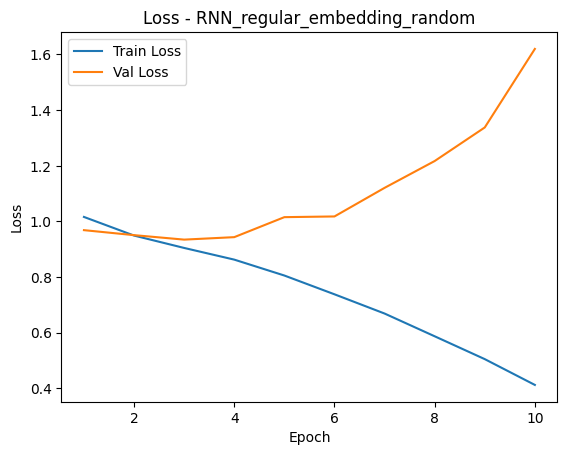

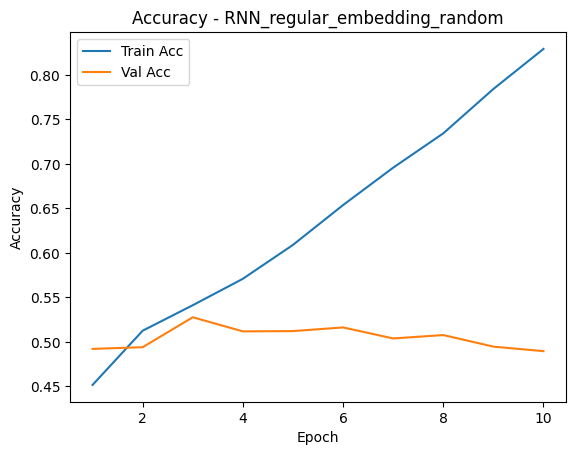

              precision    recall  f1-score   support

        easy       0.56      0.75      0.64      1050
      medium       0.46      0.39      0.42      1050
        hard       0.44      0.36      0.39      1050

    accuracy                           0.50      3150
   macro avg       0.49      0.50      0.49      3150
weighted avg       0.49      0.50      0.49      3150



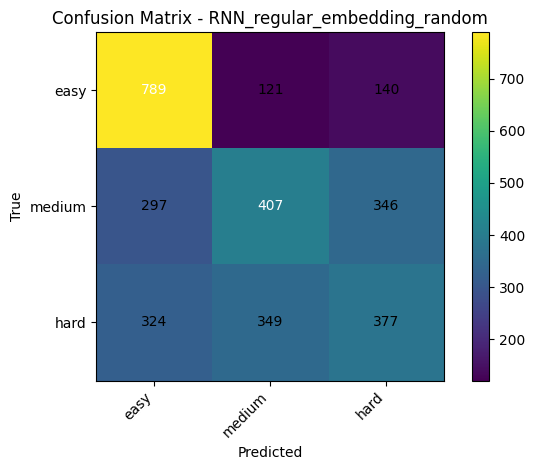

In [62]:
# ========= RUN: RNN + REGULAR (RANDOM) EMBEDDING =========

cfg_rnn_regular = ExperimentConfig(
    experiment_name="RNN_regular_embedding_random",
    model_type="RNN",
    hidden_dim=128,
    num_layers=1,
    dropout=0.0,                 # set 0.0 to disable dropout
    embedding_source="random",   # <-- REGULAR embedding
    embedding_trainable=True,    # irrelevant for random, but fine to keep
    lr=0.001,
    max_epochs=10,
    batch_size=64,               # <-- CONTROL HERE
    use_early_stopping=False,
    patience=3,
    log_every_epoch=True
)

# 1) Header logs (your function)
print_experiment_header(cfg_rnn_regular)

# 2) Loaders controlled by cfg.batch_size
train_loader, val_loader, test_loader = make_loaders(
    cfg_rnn_regular,
    train_ids, train_attn, y_train,
    val_ids, val_attn, y_val,
    test_ids, test_attn, y_test
)

# 3) Train (your function)
model_rnn_regular, history_rnn_regular = train_model(cfg_rnn_regular, train_loader, val_loader)

# 4) Curves (your function)
plot_training_curves(history_rnn_regular, cfg_rnn_regular.experiment_name)

# 5) Evaluate on test + Confusion Matrix (your functions)
cm_rnn_regular = evaluate(model_rnn_regular)
plot_confusion_matrix(cm_rnn_regular, ["easy", "medium", "hard"], cfg_rnn_regular.experiment_name)


OVERFITING

DROPOUT ננסה להוסיף

EXPERIMENT: RNN_regular_embedding_random
Model: RNN | hidden=128 | layers=1 | dropout=0.3
Embedding: random | trainable=True
Train: lr=0.001 | batch_size=64 | epochs=10
EarlyStopping: False | patience=3
[RNN_regular_embedding_random] Epoch 1/10 | train_loss=1.0369 train_acc=0.4404 | val_loss=0.9804 val_acc=0.5010
[RNN_regular_embedding_random] Epoch 2/10 | train_loss=0.9647 train_acc=0.5020 | val_loss=0.9660 val_acc=0.5092
[RNN_regular_embedding_random] Epoch 3/10 | train_loss=0.9218 train_acc=0.5377 | val_loss=0.9481 val_acc=0.5121
[RNN_regular_embedding_random] Epoch 4/10 | train_loss=0.8722 train_acc=0.5667 | val_loss=0.9636 val_acc=0.5016
[RNN_regular_embedding_random] Epoch 5/10 | train_loss=0.8425 train_acc=0.5903 | val_loss=0.9668 val_acc=0.5159
[RNN_regular_embedding_random] Epoch 6/10 | train_loss=0.7761 train_acc=0.6295 | val_loss=0.9946 val_acc=0.4978
[RNN_regular_embedding_random] Epoch 7/10 | train_loss=0.7067 train_acc=0.6733 | val_loss=1.0844 val_acc=0.5095
[RNN_regular_

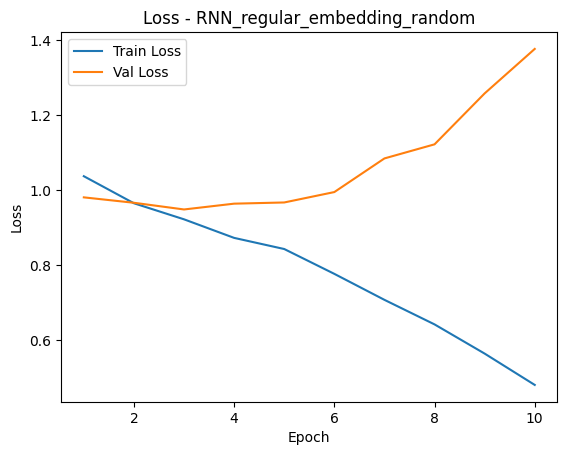

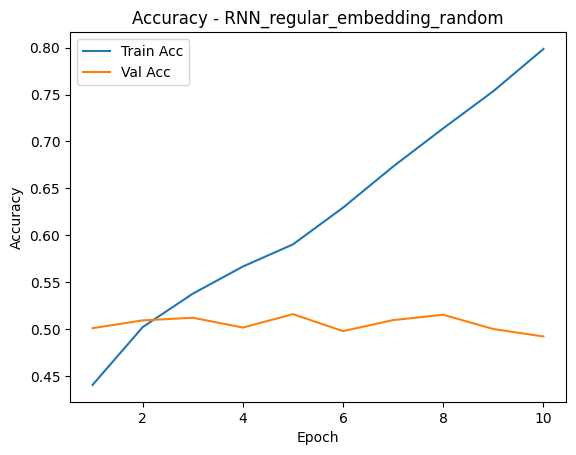

              precision    recall  f1-score   support

        easy       0.64      0.62      0.63      1050
      medium       0.42      0.29      0.35      1050
        hard       0.41      0.55      0.47      1050

    accuracy                           0.49      3150
   macro avg       0.49      0.49      0.48      3150
weighted avg       0.49      0.49      0.48      3150



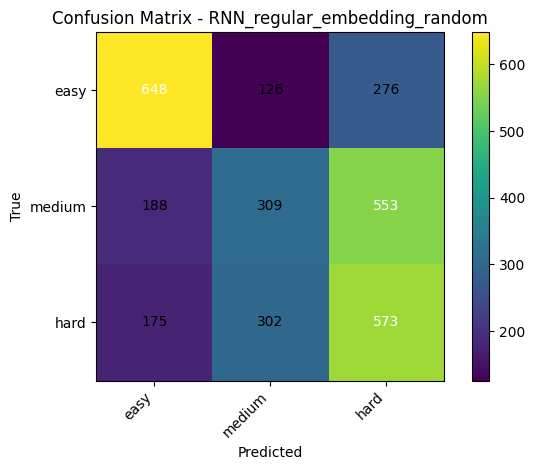

In [61]:
# ========= RUN: RNN + REGULAR (RANDOM) EMBEDDING =========

cfg_rnn_regular = ExperimentConfig(
    experiment_name="RNN_regular_embedding_random",
    model_type="RNN",
    hidden_dim=128,
    num_layers=1,
    dropout=0.3,                 # set 0.0 to disable dropout
    embedding_source="random",   # <-- REGULAR embedding
    embedding_trainable=True,    # irrelevant for random, but fine to keep
    lr=0.001,
    max_epochs=10,
    batch_size=64,               # <-- CONTROL HERE
    use_early_stopping=False,
    patience=3,
    log_every_epoch=True
)

# 1) Header logs (your function)
print_experiment_header(cfg_rnn_regular)

# 2) Loaders controlled by cfg.batch_size
train_loader, val_loader, test_loader = make_loaders(
    cfg_rnn_regular,
    train_ids, train_attn, y_train,
    val_ids, val_attn, y_val,
    test_ids, test_attn, y_test
)

# 3) Train (your function)
model_rnn_regular, history_rnn_regular = train_model(cfg_rnn_regular, train_loader, val_loader)

# 4) Curves (your function)
plot_training_curves(history_rnn_regular, cfg_rnn_regular.experiment_name)

# 5) Evaluate on test + Confusion Matrix (your functions)
cm_rnn_regular = evaluate(model_rnn_regular)
plot_confusion_matrix(cm_rnn_regular, ["easy", "medium", "hard"], cfg_rnn_regular.experiment_name)


עדיין קיבלנו אוברפיטינג לכן ננסה להקטין את המודל לתקן זאת

EXPERIMENT: RNN_regular_embedding_random
Model: RNN | hidden=64 | layers=1 | dropout=0.3
Embedding: random | trainable=True
Train: lr=0.001 | batch_size=64 | epochs=10
EarlyStopping: False | patience=3
[RNN_regular_embedding_random] Epoch 1/10 | train_loss=1.0658 train_acc=0.4102 | val_loss=0.9882 val_acc=0.4768
[RNN_regular_embedding_random] Epoch 2/10 | train_loss=0.9707 train_acc=0.4995 | val_loss=0.9845 val_acc=0.4800
[RNN_regular_embedding_random] Epoch 3/10 | train_loss=0.9191 train_acc=0.5297 | val_loss=0.9618 val_acc=0.5054
[RNN_regular_embedding_random] Epoch 4/10 | train_loss=0.8749 train_acc=0.5595 | val_loss=0.9703 val_acc=0.5111
[RNN_regular_embedding_random] Epoch 5/10 | train_loss=0.8306 train_acc=0.5944 | val_loss=0.9941 val_acc=0.5184
[RNN_regular_embedding_random] Epoch 6/10 | train_loss=0.7793 train_acc=0.6189 | val_loss=1.0110 val_acc=0.5206
[RNN_regular_embedding_random] Epoch 7/10 | train_loss=0.7265 train_acc=0.6566 | val_loss=1.0402 val_acc=0.5171
[RNN_regular_e

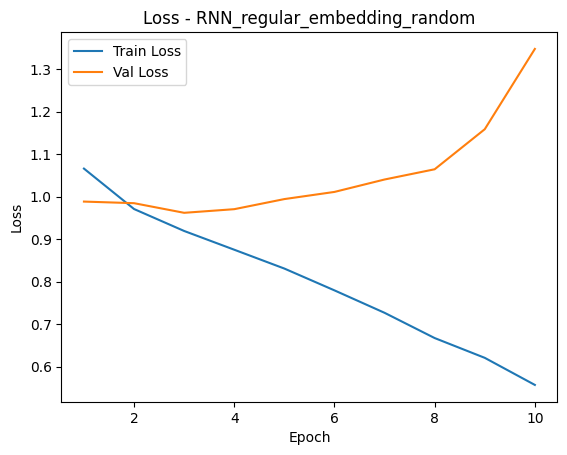

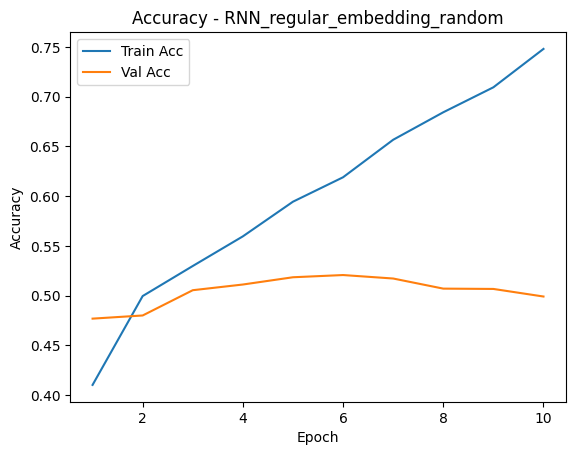

              precision    recall  f1-score   support

        easy       0.59      0.69      0.63      1050
      medium       0.44      0.38      0.41      1050
        hard       0.41      0.40      0.41      1050

    accuracy                           0.49      3150
   macro avg       0.48      0.49      0.48      3150
weighted avg       0.48      0.49      0.48      3150



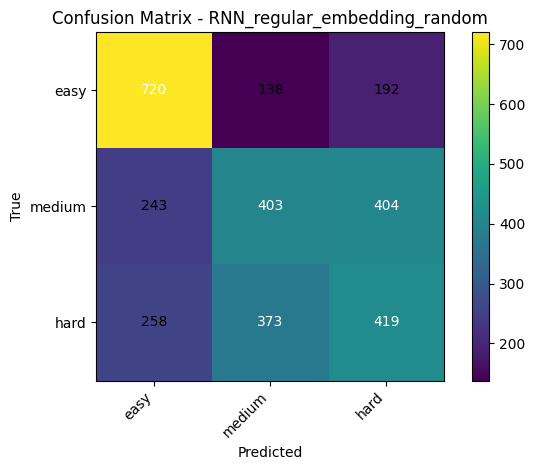

In [82]:
# ========= RUN: RNN + REGULAR (RANDOM) EMBEDDING =========

cfg_rnn_regular = ExperimentConfig(
    experiment_name="RNN_regular_embedding_random",
    model_type="RNN",
    hidden_dim=64,
    num_layers=1,
    dropout=0.3,                 # set 0.0 to disable dropout
    embedding_source="random",   # <-- REGULAR embedding
    embedding_trainable=True,    # irrelevant for random, but fine to keep
    lr=0.001,
    max_epochs=10,
    batch_size=64,               # <-- CONTROL HERE
    use_early_stopping=False,
    patience=3,
    log_every_epoch=True
)

# 1) Header logs (your function)
print_experiment_header(cfg_rnn_regular)

# 2) Loaders controlled by cfg.batch_size
train_loader, val_loader, test_loader = make_loaders(
    cfg_rnn_regular,
    train_ids, train_attn, y_train,
    val_ids, val_attn, y_val,
    test_ids, test_attn, y_test
)

# 3) Train (your function)
model_rnn_regular, history_rnn_regular = train_model(cfg_rnn_regular, train_loader, val_loader)

# 4) Curves (your function)
plot_training_curves(history_rnn_regular, cfg_rnn_regular.experiment_name)

# 5) Evaluate on test + Confusion Matrix (your functions)
cm_rnn_regular = evaluate(model_rnn_regular)
plot_confusion_matrix(cm_rnn_regular, ["easy", "medium", "hard"], cfg_rnn_regular.experiment_name)


**RNN + W2V FRUZEN EMBEDDING**

EXPERIMENT: RNN_w2v_frozen
Model: RNN | hidden=128 | layers=1 | dropout=0.0
Embedding: w2v | trainable=False
Train: lr=0.001 | batch_size=64 | epochs=10
EarlyStopping: False | patience=3
[RNN_w2v_frozen] Epoch 1/10 | train_loss=1.0213 train_acc=0.4508 | val_loss=0.9834 val_acc=0.5086
[RNN_w2v_frozen] Epoch 2/10 | train_loss=0.9694 train_acc=0.4941 | val_loss=1.0437 val_acc=0.4870
[RNN_w2v_frozen] Epoch 3/10 | train_loss=0.9414 train_acc=0.5102 | val_loss=0.9223 val_acc=0.5244
[RNN_w2v_frozen] Epoch 4/10 | train_loss=0.9219 train_acc=0.5169 | val_loss=0.9096 val_acc=0.5308
[RNN_w2v_frozen] Epoch 5/10 | train_loss=0.9214 train_acc=0.5193 | val_loss=0.9209 val_acc=0.5111
[RNN_w2v_frozen] Epoch 6/10 | train_loss=0.9007 train_acc=0.5326 | val_loss=0.9167 val_acc=0.5184
[RNN_w2v_frozen] Epoch 7/10 | train_loss=0.9004 train_acc=0.5354 | val_loss=0.9714 val_acc=0.4879
[RNN_w2v_frozen] Epoch 8/10 | train_loss=0.8915 train_acc=0.5414 | val_loss=0.8917 val_acc=0.5321
[RNN_w2v_frozen] Epoch 9/10 |

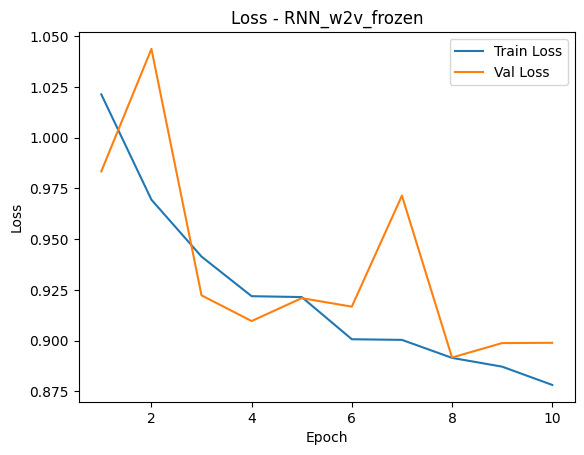

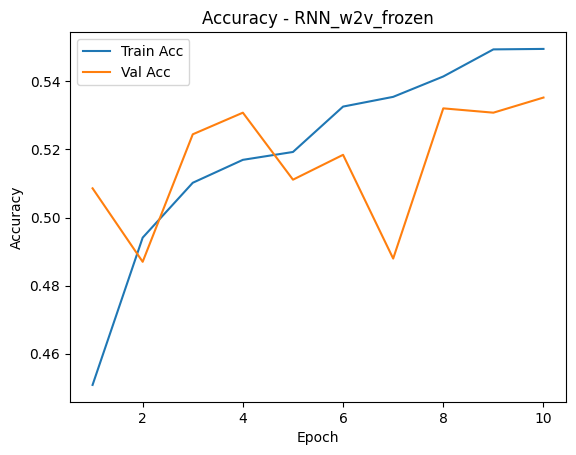

              precision    recall  f1-score   support

        easy       0.84      0.58      0.69      1050
      medium       0.41      0.33      0.37      1050
        hard       0.40      0.61      0.49      1050

    accuracy                           0.51      3150
   macro avg       0.55      0.51      0.51      3150
weighted avg       0.55      0.51      0.51      3150



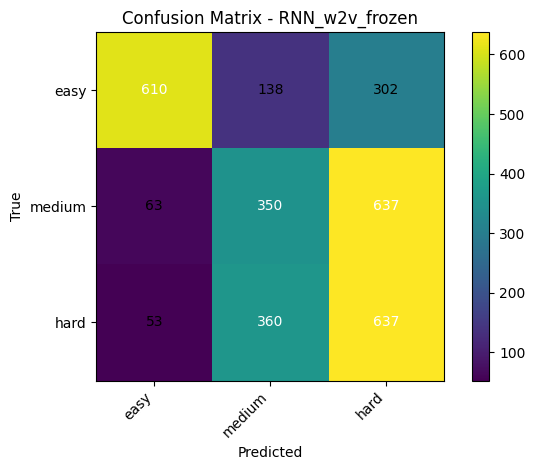

In [59]:
# ========= RUN: RNN + W2V FROZEN EMBEDDING =========

cfg_rnn_w2v_frozen = ExperimentConfig(
    experiment_name="RNN_w2v_frozen",
    model_type="RNN",
    hidden_dim=128,
    num_layers=1,
    dropout=0.0,
    embedding_source="w2v",
    embedding_trainable=False,   # <-- FROZEN
    lr=0.001,
    max_epochs=10,
    batch_size=64,
    use_early_stopping=False,
    patience=3,
    log_every_epoch=True
)

print_experiment_header(cfg_rnn_w2v_frozen)

train_loader, val_loader, test_loader = make_loaders(
    cfg_rnn_w2v_frozen,
    train_ids, train_attn, y_train,
    val_ids, val_attn, y_val,
    test_ids, test_attn, y_test
)

model_rnn_w2v_frozen, hist_rnn_w2v_frozen = train_model(cfg_rnn_w2v_frozen, train_loader, val_loader)

plot_training_curves(hist_rnn_w2v_frozen, cfg_rnn_w2v_frozen.experiment_name)

cm_rnn_w2v_frozen = evaluate(model_rnn_w2v_frozen)
plot_confusion_matrix(cm_rnn_w2v_frozen, ["easy", "medium", "hard"], cfg_rnn_w2v_frozen.experiment_name)


# **LSTM + REGULAR EMBEDDING**

EXPERIMENT: LSTM_regular_no_dropout_no_es_10ep
Model: LSTM | hidden=128 | layers=1 | dropout=0.0
Embedding: random | trainable=True
Train: lr=0.001 | batch_size=64 | epochs=10
EarlyStopping: False | patience=3
[LSTM_regular_no_dropout_no_es_10ep] Epoch 1/10 | train_loss=0.9699 train_acc=0.4754 | val_loss=0.9125 val_acc=0.5210
[LSTM_regular_no_dropout_no_es_10ep] Epoch 2/10 | train_loss=0.8902 train_acc=0.5327 | val_loss=0.8970 val_acc=0.5317
[LSTM_regular_no_dropout_no_es_10ep] Epoch 3/10 | train_loss=0.8418 train_acc=0.5707 | val_loss=0.9006 val_acc=0.5397
[LSTM_regular_no_dropout_no_es_10ep] Epoch 4/10 | train_loss=0.7820 train_acc=0.6115 | val_loss=0.9035 val_acc=0.5362
[LSTM_regular_no_dropout_no_es_10ep] Epoch 5/10 | train_loss=0.7072 train_acc=0.6576 | val_loss=0.9396 val_acc=0.5327
[LSTM_regular_no_dropout_no_es_10ep] Epoch 6/10 | train_loss=0.6116 train_acc=0.7180 | val_loss=1.0347 val_acc=0.5251
[LSTM_regular_no_dropout_no_es_10ep] Epoch 7/10 | train_loss=0.4973 train_acc=0.77

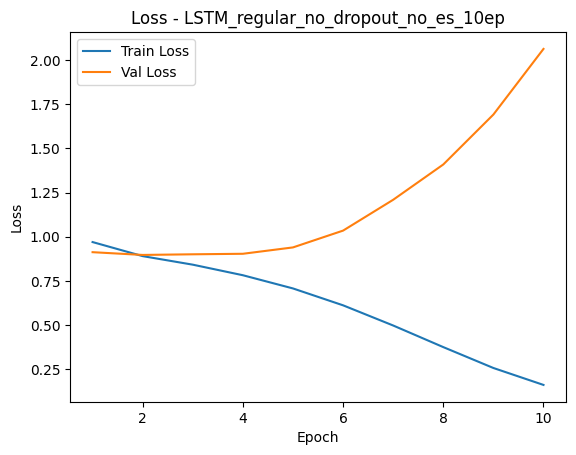

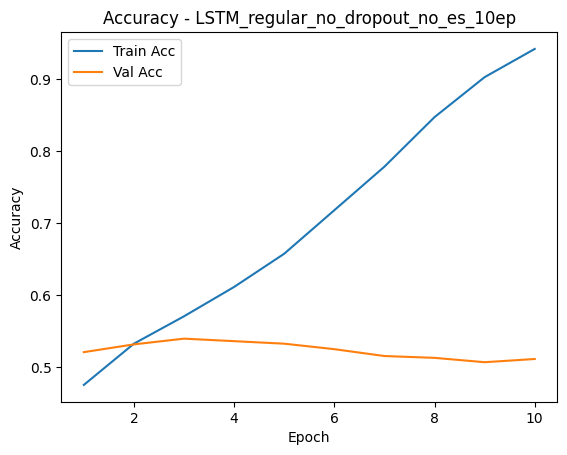

              precision    recall  f1-score   support

        easy       0.70      0.63      0.66      1050
      medium       0.44      0.45      0.44      1050
        hard       0.42      0.45      0.44      1050

    accuracy                           0.51      3150
   macro avg       0.52      0.51      0.51      3150
weighted avg       0.52      0.51      0.51      3150



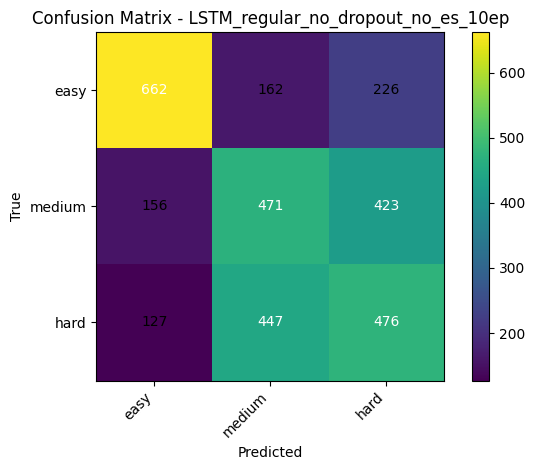

In [80]:
# ========= RUN: LSTM + REGULAR (no dropout, no early stopping, 10 epochs) =========

cfg_lstm_regular = ExperimentConfig(
    experiment_name="LSTM_regular_no_dropout_no_es_10ep",
    model_type="LSTM",
    hidden_dim=128,
    num_layers=1,
    dropout=0.0,
    embedding_source="random",
    embedding_trainable=True,
    lr=0.001,
    max_epochs=10,
    batch_size=64,
    use_early_stopping=False,
    patience=3,
    log_every_epoch=True
)

print_experiment_header(cfg_lstm_regular)

train_loader, val_loader, test_loader = make_loaders(
    cfg_lstm_regular,
    train_ids, train_attn, y_train,
    val_ids, val_attn, y_val,
    test_ids, test_attn, y_test
)

model_lstm_regular, hist_lstm_regular = train_model(cfg_lstm_regular, train_loader, val_loader)

plot_training_curves(hist_lstm_regular, cfg_lstm_regular.experiment_name)

cm_lstm_regular = evaluate(model_lstm_regular)
plot_confusion_matrix(cm_lstm_regular, ["easy", "medium", "hard"], cfg_lstm_regular.experiment_name)


אוברפיטינג ברור ננסה להוסיף דרופאוט

EXPERIMENT: LSTM_regular__no_es_10ep
Model: LSTM | hidden=128 | layers=1 | dropout=0.3
Embedding: random | trainable=True
Train: lr=0.001 | batch_size=64 | epochs=10
EarlyStopping: False | patience=3
[LSTM_regular__no_es_10ep] Epoch 1/10 | train_loss=0.9765 train_acc=0.4758 | val_loss=0.8993 val_acc=0.5168
[LSTM_regular__no_es_10ep] Epoch 2/10 | train_loss=0.8914 train_acc=0.5387 | val_loss=0.8888 val_acc=0.5365
[LSTM_regular__no_es_10ep] Epoch 3/10 | train_loss=0.8458 train_acc=0.5704 | val_loss=0.8889 val_acc=0.5263
[LSTM_regular__no_es_10ep] Epoch 4/10 | train_loss=0.7907 train_acc=0.6064 | val_loss=0.9183 val_acc=0.5340
[LSTM_regular__no_es_10ep] Epoch 5/10 | train_loss=0.7280 train_acc=0.6477 | val_loss=0.9633 val_acc=0.5330
[LSTM_regular__no_es_10ep] Epoch 6/10 | train_loss=0.6471 train_acc=0.6973 | val_loss=1.0173 val_acc=0.5133
[LSTM_regular__no_es_10ep] Epoch 7/10 | train_loss=0.5409 train_acc=0.7610 | val_loss=1.1819 val_acc=0.5184
[LSTM_regular__no_es_10ep] Epoch 8/10 | trai

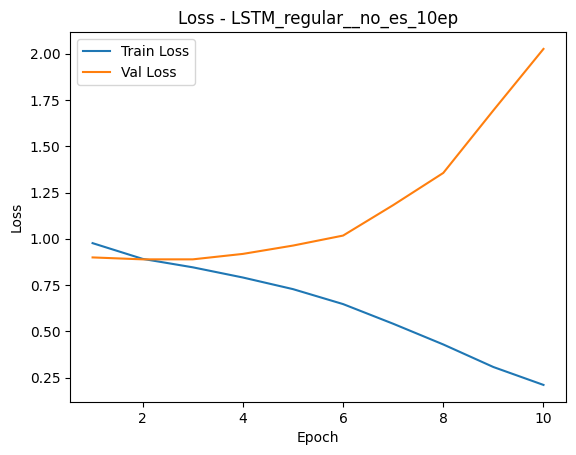

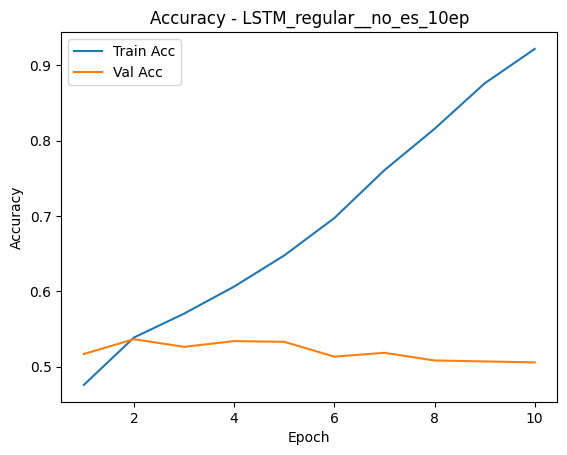

              precision    recall  f1-score   support

        easy       0.68      0.67      0.67      1050
      medium       0.43      0.45      0.44      1050
        hard       0.41      0.40      0.40      1050

    accuracy                           0.51      3150
   macro avg       0.51      0.51      0.51      3150
weighted avg       0.51      0.51      0.51      3150



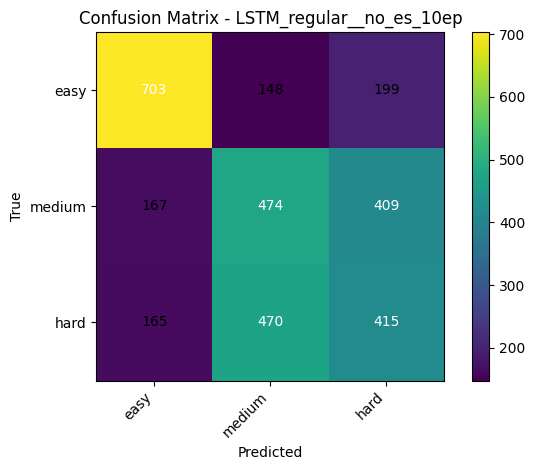

In [79]:
# ========= RUN: LSTM + REGULAR  =========

cfg_lstm_regular = ExperimentConfig(
    experiment_name="LSTM_regular__no_es_10ep",
    model_type="LSTM",
    hidden_dim=128,
    num_layers=1,
    dropout=0.3,
    embedding_source="random",
    embedding_trainable=True,
    lr=0.001,
    max_epochs=10,
    batch_size=64,
    use_early_stopping=False,
    patience=3,
    log_every_epoch=True
)

print_experiment_header(cfg_lstm_regular)

train_loader, val_loader, test_loader = make_loaders(
    cfg_lstm_regular,
    train_ids, train_attn, y_train,
    val_ids, val_attn, y_val,
    test_ids, test_attn, y_test
)

model_lstm_regular, hist_lstm_regular = train_model(cfg_lstm_regular, train_loader, val_loader)

plot_training_curves(hist_lstm_regular, cfg_lstm_regular.experiment_name)

cm_lstm_regular = evaluate(model_lstm_regular)
plot_confusion_matrix(cm_lstm_regular, ["easy", "medium", "hard"], cfg_lstm_regular.experiment_name)


עדיין אוברפיטינג ננסה הקטנת המודל

EXPERIMENT: LSTM_regular__no_es_10ep
Model: LSTM | hidden=64 | layers=1 | dropout=0.3
Embedding: random | trainable=True
Train: lr=0.001 | batch_size=64 | epochs=10
EarlyStopping: False | patience=3
[LSTM_regular__no_es_10ep] Epoch 1/10 | train_loss=0.9963 train_acc=0.4571 | val_loss=0.9258 val_acc=0.5095
[LSTM_regular__no_es_10ep] Epoch 2/10 | train_loss=0.8998 train_acc=0.5292 | val_loss=0.8968 val_acc=0.5368
[LSTM_regular__no_es_10ep] Epoch 3/10 | train_loss=0.8558 train_acc=0.5598 | val_loss=0.8889 val_acc=0.5311
[LSTM_regular__no_es_10ep] Epoch 4/10 | train_loss=0.8038 train_acc=0.5910 | val_loss=0.9057 val_acc=0.5365
[LSTM_regular__no_es_10ep] Epoch 5/10 | train_loss=0.7510 train_acc=0.6324 | val_loss=0.9328 val_acc=0.5257
[LSTM_regular__no_es_10ep] Epoch 6/10 | train_loss=0.6961 train_acc=0.6650 | val_loss=1.0039 val_acc=0.5263
[LSTM_regular__no_es_10ep] Epoch 7/10 | train_loss=0.6229 train_acc=0.7141 | val_loss=1.1029 val_acc=0.5213
[LSTM_regular__no_es_10ep] Epoch 8/10 | train

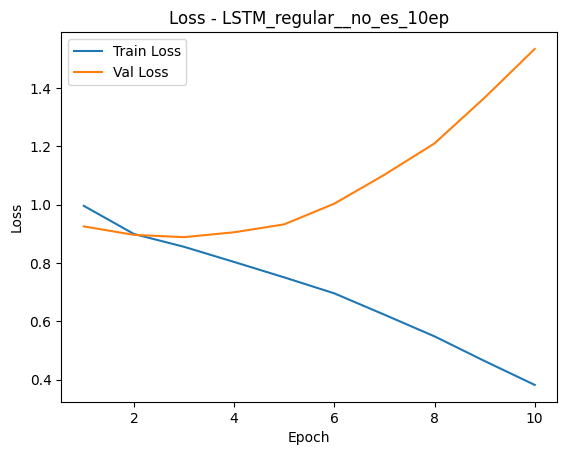

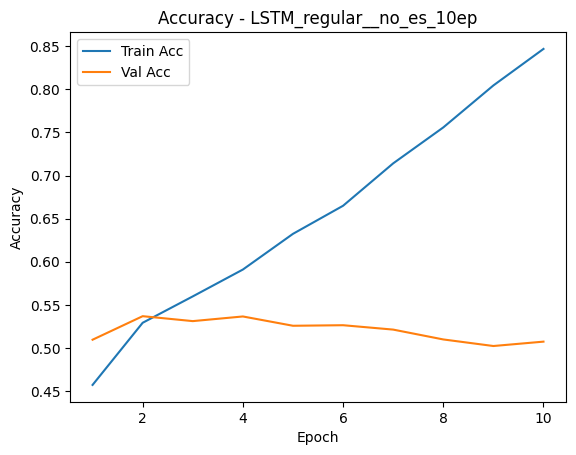

              precision    recall  f1-score   support

        easy       0.68      0.65      0.67      1050
      medium       0.44      0.36      0.39      1050
        hard       0.42      0.51      0.46      1050

    accuracy                           0.51      3150
   macro avg       0.51      0.51      0.51      3150
weighted avg       0.51      0.51      0.51      3150



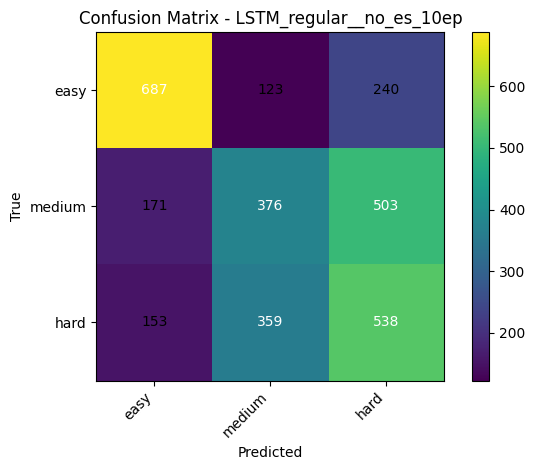

In [78]:
# ========= RUN: LSTM + REGULAR  =========

cfg_lstm_regular = ExperimentConfig(
    experiment_name="LSTM_regular__no_es_10ep",
    model_type="LSTM",
    hidden_dim=64,
    num_layers=1,
    dropout=0.3,
    embedding_source="random",
    embedding_trainable=True,
    lr=0.001,
    max_epochs=10,
    batch_size=64,
    use_early_stopping=False,
    patience=3,
    log_every_epoch=True
)

print_experiment_header(cfg_lstm_regular)

train_loader, val_loader, test_loader = make_loaders(
    cfg_lstm_regular,
    train_ids, train_attn, y_train,
    val_ids, val_attn, y_val,
    test_ids, test_attn, y_test
)

model_lstm_regular, hist_lstm_regular = train_model(cfg_lstm_regular, train_loader, val_loader)

plot_training_curves(hist_lstm_regular, cfg_lstm_regular.experiment_name)

cm_lstm_regular = evaluate(model_lstm_regular)
plot_confusion_matrix(cm_lstm_regular, ["easy", "medium", "hard"], cfg_lstm_regular.experiment_name)


**LSTM + W2V FROZEN EMBEDDINGש**

EXPERIMENT: LSTM_w2v_frozen_no_dropout_no_es_10ep
Model: LSTM | hidden=128 | layers=1 | dropout=0.0
Embedding: w2v | trainable=False
Train: lr=0.001 | batch_size=64 | epochs=10
EarlyStopping: False | patience=3
[LSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 1/10 | train_loss=0.9814 train_acc=0.4687 | val_loss=0.9163 val_acc=0.5216
[LSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 2/10 | train_loss=0.9200 train_acc=0.5137 | val_loss=0.9152 val_acc=0.5165
[LSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 3/10 | train_loss=0.8994 train_acc=0.5303 | val_loss=0.9005 val_acc=0.5298
[LSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 4/10 | train_loss=0.8865 train_acc=0.5364 | val_loss=0.8800 val_acc=0.5330
[LSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 5/10 | train_loss=0.8731 train_acc=0.5491 | val_loss=0.8703 val_acc=0.5362
[LSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 6/10 | train_loss=0.8601 train_acc=0.5514 | val_loss=0.8701 val_acc=0.5384
[LSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 7/10 | train_loss

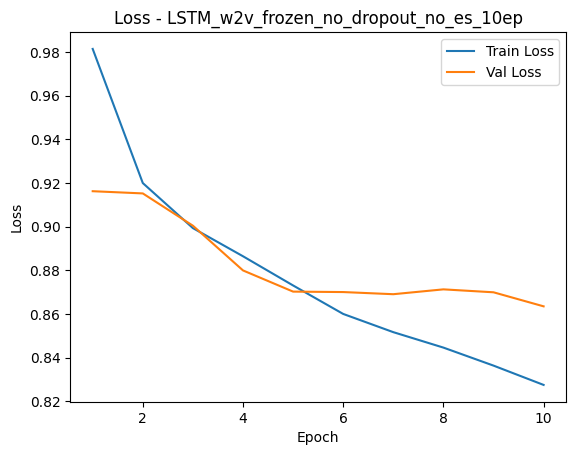

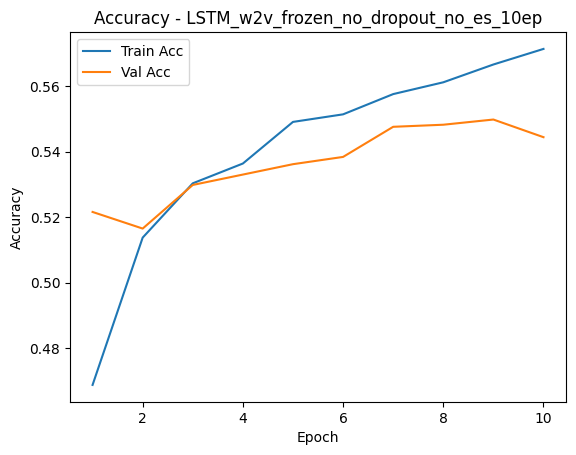

              precision    recall  f1-score   support

        easy       0.83      0.64      0.72      1050
      medium       0.46      0.68      0.55      1050
        hard       0.44      0.33      0.38      1050

    accuracy                           0.55      3150
   macro avg       0.58      0.55      0.55      3150
weighted avg       0.58      0.55      0.55      3150



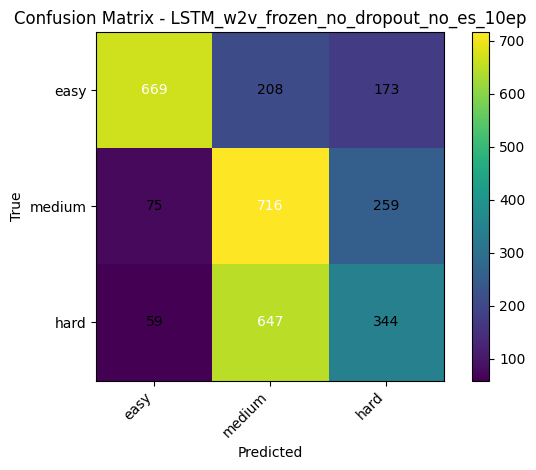

In [77]:
# ========= RUN: LSTM + W2V FROZEN ( =========

cfg_lstm_w2v_frozen = ExperimentConfig(
    experiment_name="LSTM_w2v_frozen_no_dropout_no_es_10ep",
    model_type="LSTM",
    hidden_dim=128,
    num_layers=1,
    dropout=0.0,
    embedding_source="w2v",
    embedding_trainable=False,
    lr=0.001,
    max_epochs=10,
    batch_size=64,
    use_early_stopping=False,
    patience=3,
    log_every_epoch=True
)

print_experiment_header(cfg_lstm_w2v_frozen)

train_loader, val_loader, test_loader = make_loaders(
    cfg_lstm_w2v_frozen,
    train_ids, train_attn, y_train,
    val_ids, val_attn, y_val,
    test_ids, test_attn, y_test
)

model_lstm_w2v_frozen, hist_lstm_w2v_frozen = train_model(cfg_lstm_w2v_frozen, train_loader, val_loader)

plot_training_curves(hist_lstm_w2v_frozen, cfg_lstm_w2v_frozen.experiment_name)

cm_lstm_w2v_frozen = evaluate(model_lstm_w2v_frozen)
plot_confusion_matrix(cm_lstm_w2v_frozen, ["easy", "medium", "hard"], cfg_lstm_w2v_frozen.experiment_name)


**BiLSTM + REGULAR EMBEDDING**

EXPERIMENT: BiLSTM_regular_no_dropout_no_es_10ep
Model: BiLSTM | hidden=128 | layers=1 | dropout=0.0
Embedding: random | trainable=True
Train: lr=0.001 | batch_size=64 | epochs=10
EarlyStopping: False | patience=3
[BiLSTM_regular_no_dropout_no_es_10ep] Epoch 1/10 | train_loss=0.9697 train_acc=0.4722 | val_loss=0.9019 val_acc=0.5146
[BiLSTM_regular_no_dropout_no_es_10ep] Epoch 2/10 | train_loss=0.8899 train_acc=0.5272 | val_loss=0.8830 val_acc=0.5267
[BiLSTM_regular_no_dropout_no_es_10ep] Epoch 3/10 | train_loss=0.8381 train_acc=0.5681 | val_loss=0.9319 val_acc=0.5206
[BiLSTM_regular_no_dropout_no_es_10ep] Epoch 4/10 | train_loss=0.7808 train_acc=0.6120 | val_loss=0.9143 val_acc=0.5365
[BiLSTM_regular_no_dropout_no_es_10ep] Epoch 5/10 | train_loss=0.6971 train_acc=0.6680 | val_loss=0.9731 val_acc=0.5346
[BiLSTM_regular_no_dropout_no_es_10ep] Epoch 6/10 | train_loss=0.5940 train_acc=0.7307 | val_loss=1.0816 val_acc=0.5203
[BiLSTM_regular_no_dropout_no_es_10ep] Epoch 7/10 | train_loss=0.4

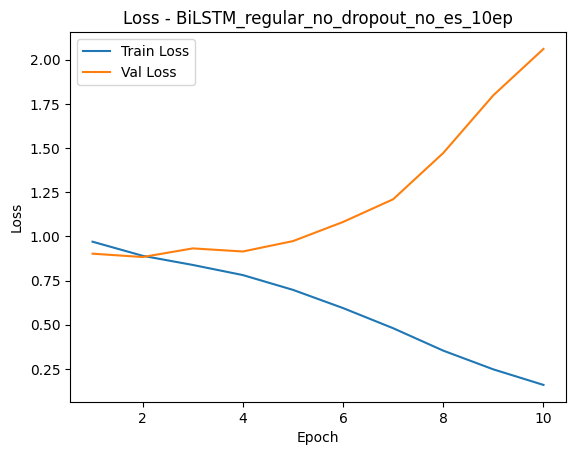

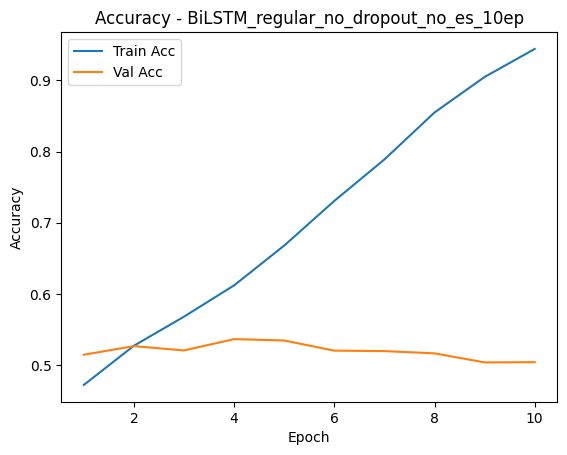

              precision    recall  f1-score   support

        easy       0.70      0.64      0.67      1050
      medium       0.43      0.38      0.40      1050
        hard       0.42      0.51      0.46      1050

    accuracy                           0.51      3150
   macro avg       0.52      0.51      0.51      3150
weighted avg       0.52      0.51      0.51      3150



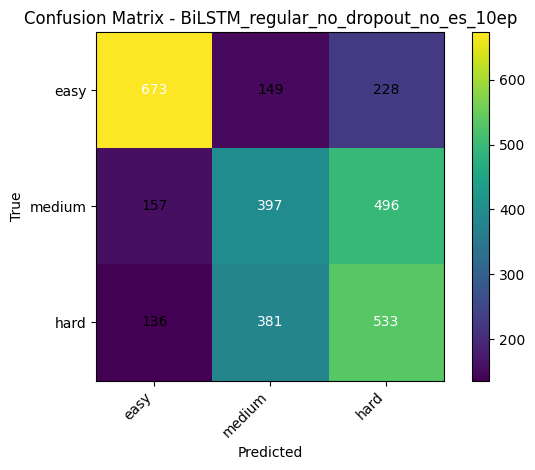

In [75]:
# ========= RUN: BiLSTM + REGULAR  =========

cfg_bilstm_regular = ExperimentConfig(
    experiment_name="BiLSTM_regular_no_dropout_no_es_10ep",
    model_type="BiLSTM",
    hidden_dim=128,
    num_layers=1,
    dropout=0.0,
    embedding_source="random",
    embedding_trainable=True,
    lr=0.001,
    max_epochs=10,
    batch_size=64,
    use_early_stopping=False,
    patience=3,
    log_every_epoch=True
)

print_experiment_header(cfg_bilstm_regular)

train_loader, val_loader, test_loader = make_loaders(
    cfg_bilstm_regular,
    train_ids, train_attn, y_train,
    val_ids, val_attn, y_val,
    test_ids, test_attn, y_test
)

model_bilstm_regular, hist_bilstm_regular = train_model(cfg_bilstm_regular, train_loader, val_loader)

plot_training_curves(hist_bilstm_regular, cfg_bilstm_regular.experiment_name)

cm_bilstm_regular = evaluate(model_bilstm_regular)
plot_confusion_matrix(cm_bilstm_regular, ["easy", "medium", "hard"], cfg_bilstm_regular.experiment_name)


יש אוברפיטינג ננסה להוסיף דרופאוט

EXPERIMENT: BiLSTM_regular_no_es_10ep
Model: BiLSTM | hidden=128 | layers=1 | dropout=0.3
Embedding: random | trainable=True
Train: lr=0.001 | batch_size=64 | epochs=10
EarlyStopping: False | patience=3
[BiLSTM_regular_no_es_10ep] Epoch 1/10 | train_loss=0.9711 train_acc=0.4747 | val_loss=0.9234 val_acc=0.5073
[BiLSTM_regular_no_es_10ep] Epoch 2/10 | train_loss=0.8916 train_acc=0.5341 | val_loss=0.8772 val_acc=0.5356
[BiLSTM_regular_no_es_10ep] Epoch 3/10 | train_loss=0.8432 train_acc=0.5707 | val_loss=0.8826 val_acc=0.5302
[BiLSTM_regular_no_es_10ep] Epoch 4/10 | train_loss=0.7915 train_acc=0.6031 | val_loss=0.8988 val_acc=0.5219
[BiLSTM_regular_no_es_10ep] Epoch 5/10 | train_loss=0.7299 train_acc=0.6485 | val_loss=0.9376 val_acc=0.5210
[BiLSTM_regular_no_es_10ep] Epoch 6/10 | train_loss=0.6441 train_acc=0.7020 | val_loss=1.0060 val_acc=0.5248
[BiLSTM_regular_no_es_10ep] Epoch 7/10 | train_loss=0.5443 train_acc=0.7596 | val_loss=1.1075 val_acc=0.5013
[BiLSTM_regular_no_es_10ep] Epoch 

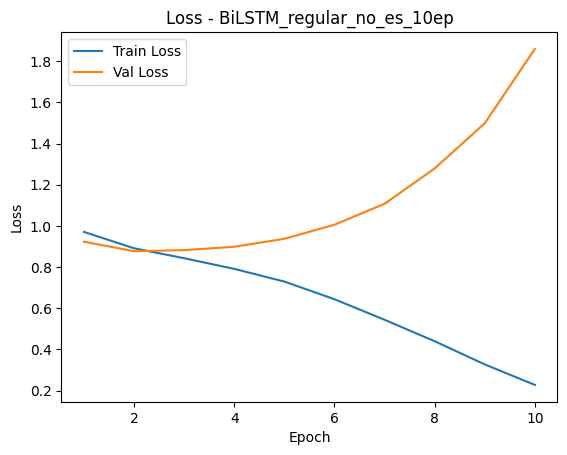

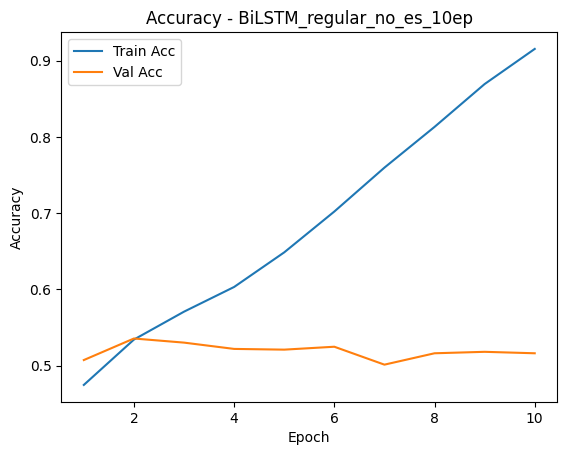

              precision    recall  f1-score   support

        easy       0.68      0.65      0.66      1050
      medium       0.42      0.43      0.43      1050
        hard       0.41      0.42      0.42      1050

    accuracy                           0.50      3150
   macro avg       0.50      0.50      0.50      3150
weighted avg       0.50      0.50      0.50      3150



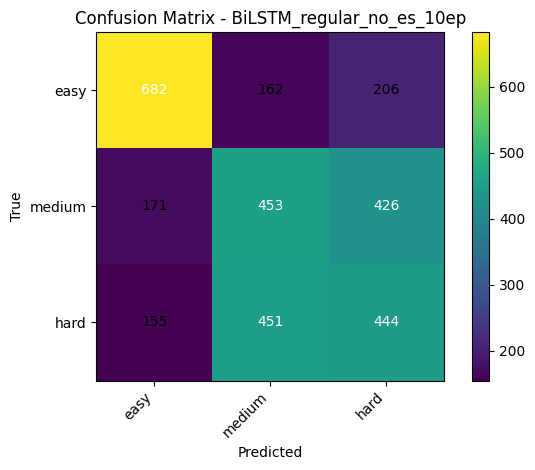

In [74]:
# ========= RUN: BiLSTM + REGULAR  =========

cfg_bilstm_regular = ExperimentConfig(
    experiment_name="BiLSTM_regular_no_es_10ep",
    model_type="BiLSTM",
    hidden_dim=128,
    num_layers=1,
    dropout=0.3,
    embedding_source="random",
    embedding_trainable=True,
    lr=0.001,
    max_epochs=10,
    batch_size=64,
    use_early_stopping=False,
    patience=3,
    log_every_epoch=True
)

print_experiment_header(cfg_bilstm_regular)

train_loader, val_loader, test_loader = make_loaders(
    cfg_bilstm_regular,
    train_ids, train_attn, y_train,
    val_ids, val_attn, y_val,
    test_ids, test_attn, y_test
)

model_bilstm_regular, hist_bilstm_regular = train_model(cfg_bilstm_regular, train_loader, val_loader)

plot_training_curves(hist_bilstm_regular, cfg_bilstm_regular.experiment_name)

cm_bilstm_regular = evaluate(model_bilstm_regular)
plot_confusion_matrix(cm_bilstm_regular, ["easy", "medium", "hard"], cfg_bilstm_regular.experiment_name)


לא עזר ננסה הקטנת המודל

EXPERIMENT: BiLSTM_regular_no_es_10ep
Model: BiLSTM | hidden=64 | layers=1 | dropout=0.3
Embedding: random | trainable=True
Train: lr=0.001 | batch_size=64 | epochs=10
EarlyStopping: False | patience=3
[BiLSTM_regular_no_es_10ep] Epoch 1/10 | train_loss=0.9886 train_acc=0.4647 | val_loss=0.9193 val_acc=0.5117
[BiLSTM_regular_no_es_10ep] Epoch 2/10 | train_loss=0.9050 train_acc=0.5226 | val_loss=0.8983 val_acc=0.5133
[BiLSTM_regular_no_es_10ep] Epoch 3/10 | train_loss=0.8547 train_acc=0.5510 | val_loss=0.8937 val_acc=0.5200
[BiLSTM_regular_no_es_10ep] Epoch 4/10 | train_loss=0.8109 train_acc=0.5860 | val_loss=0.9055 val_acc=0.5137
[BiLSTM_regular_no_es_10ep] Epoch 5/10 | train_loss=0.7507 train_acc=0.6268 | val_loss=0.9468 val_acc=0.5213
[BiLSTM_regular_no_es_10ep] Epoch 6/10 | train_loss=0.6958 train_acc=0.6584 | val_loss=0.9882 val_acc=0.5032
[BiLSTM_regular_no_es_10ep] Epoch 7/10 | train_loss=0.6267 train_acc=0.7033 | val_loss=1.0593 val_acc=0.5010
[BiLSTM_regular_no_es_10ep] Epoch 8

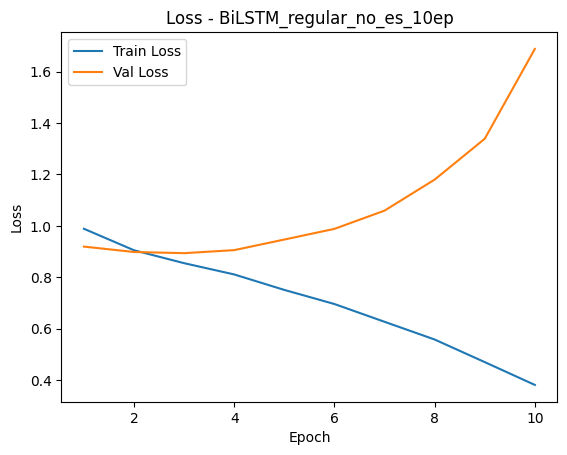

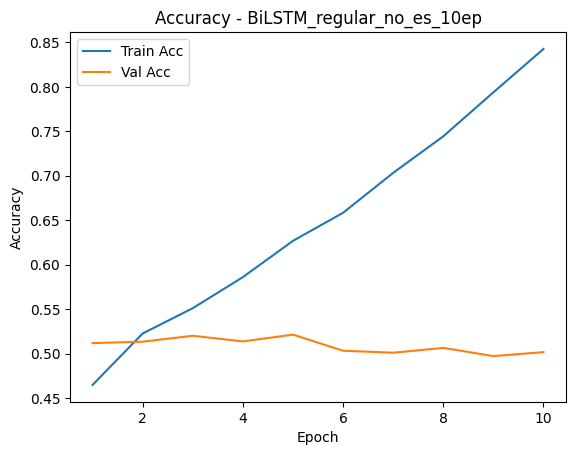

              precision    recall  f1-score   support

        easy       0.62      0.73      0.67      1050
      medium       0.44      0.37      0.40      1050
        hard       0.43      0.43      0.43      1050

    accuracy                           0.51      3150
   macro avg       0.50      0.51      0.50      3150
weighted avg       0.50      0.51      0.50      3150



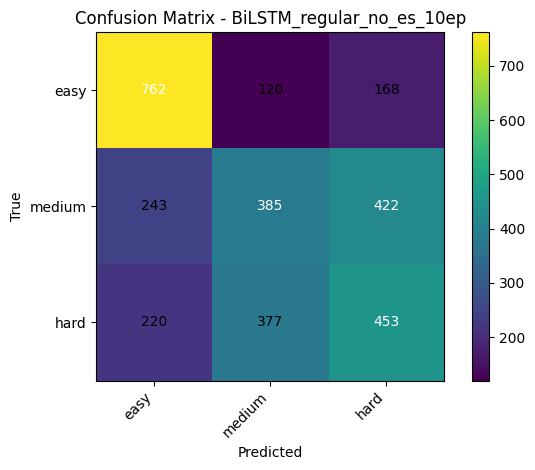

In [73]:
# ========= RUN: BiLSTM + REGULAR  =========

cfg_bilstm_regular = ExperimentConfig(
    experiment_name="BiLSTM_regular_no_es_10ep",
    model_type="BiLSTM",
    hidden_dim=64,
    num_layers=1,
    dropout=0.3,
    embedding_source="random",
    embedding_trainable=True,
    lr=0.001,
    max_epochs=10,
    batch_size=64,
    use_early_stopping=False,
    patience=3,
    log_every_epoch=True
)

print_experiment_header(cfg_bilstm_regular)

train_loader, val_loader, test_loader = make_loaders(
    cfg_bilstm_regular,
    train_ids, train_attn, y_train,
    val_ids, val_attn, y_val,
    test_ids, test_attn, y_test
)

model_bilstm_regular, hist_bilstm_regular = train_model(cfg_bilstm_regular, train_loader, val_loader)

plot_training_curves(hist_bilstm_regular, cfg_bilstm_regular.experiment_name)

cm_bilstm_regular = evaluate(model_bilstm_regular)
plot_confusion_matrix(cm_bilstm_regular, ["easy", "medium", "hard"], cfg_bilstm_regular.experiment_name)


**BiLSTM + W2V FROZEN EMBEDDING**

EXPERIMENT: BiLSTM_w2v_frozen_no_dropout_no_es_10ep
Model: BiLSTM | hidden=128 | layers=1 | dropout=0.0
Embedding: w2v | trainable=False
Train: lr=0.001 | batch_size=64 | epochs=10
EarlyStopping: False | patience=3
[BiLSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 1/10 | train_loss=0.9816 train_acc=0.4650 | val_loss=0.9255 val_acc=0.4952
[BiLSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 2/10 | train_loss=0.9202 train_acc=0.5108 | val_loss=0.8990 val_acc=0.5219
[BiLSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 3/10 | train_loss=0.8951 train_acc=0.5263 | val_loss=0.8872 val_acc=0.5305
[BiLSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 4/10 | train_loss=0.8773 train_acc=0.5371 | val_loss=0.9013 val_acc=0.5184
[BiLSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 5/10 | train_loss=0.8653 train_acc=0.5496 | val_loss=0.8651 val_acc=0.5410
[BiLSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch 6/10 | train_loss=0.8540 train_acc=0.5567 | val_loss=0.8638 val_acc=0.5371
[BiLSTM_w2v_frozen_no_dropout_no_es_10ep] Epoch

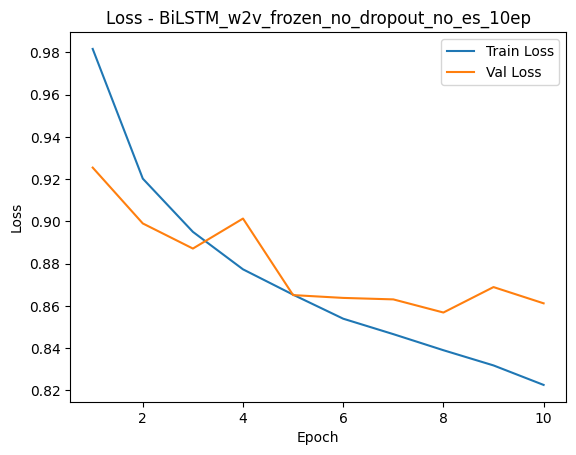

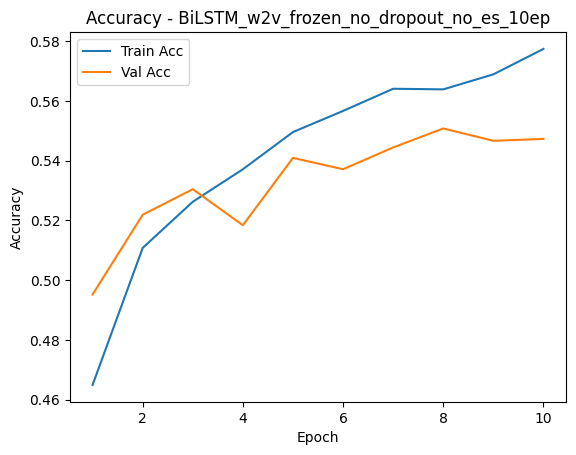

              precision    recall  f1-score   support

        easy       0.79      0.66      0.72      1050
      medium       0.46      0.58      0.51      1050
        hard       0.44      0.40      0.42      1050

    accuracy                           0.54      3150
   macro avg       0.56      0.54      0.55      3150
weighted avg       0.56      0.54      0.55      3150



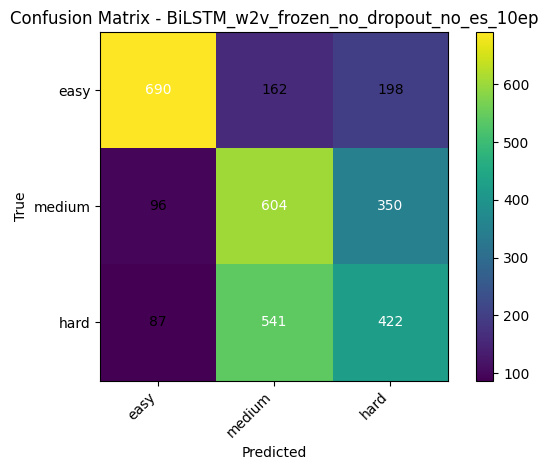

In [72]:
# ========= RUN: BiLSTM + W2V FROZEN (no dropout, no early stopping, 10 epochs) =========

cfg_bilstm_w2v_frozen = ExperimentConfig(
    experiment_name="BiLSTM_w2v_frozen_no_dropout_no_es_10ep",
    model_type="BiLSTM",
    hidden_dim=128,
    num_layers=1,
    dropout=0.0,
    embedding_source="w2v",
    embedding_trainable=False,
    lr=0.001,
    max_epochs=10,
    batch_size=64,
    use_early_stopping=False,
    patience=3,
    log_every_epoch=True
)

print_experiment_header(cfg_bilstm_w2v_frozen)

train_loader, val_loader, test_loader = make_loaders(
    cfg_bilstm_w2v_frozen,
    train_ids, train_attn, y_train,
    val_ids, val_attn, y_val,
    test_ids, test_attn, y_test
)

model_bilstm_w2v_frozen, hist_bilstm_w2v_frozen = train_model(cfg_bilstm_w2v_frozen, train_loader, val_loader)

plot_training_curves(hist_bilstm_w2v_frozen, cfg_bilstm_w2v_frozen.experiment_name)

cm_bilstm_w2v_frozen = evaluate(model_bilstm_w2v_frozen)
plot_confusion_matrix(cm_bilstm_w2v_frozen, ["easy", "medium", "hard"], cfg_bilstm_w2v_frozen.experiment_name)


# ***סיימנו להריץ את 6 הניסויים כולל ניסיון לטפל האוברפיטינג במקרה הצורך , כעת ננסה לשפר את המודלים :***

# **סיום עריכה חדשה**

# ***================================================================================================================================================================================================================================================***

# **שלב 1**

# **א**

**Choosing Maximum Sequence Length (Documentation)**

In [ ]:
!pip install tensorflow

In [3]:
import numpy as np
import torch
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. חילוץ הטקסטים
texts = df_balanced['question'].astype(str).tolist()

# 2. אתחול והתאמת הטוקנייזר על כל המילים (בלי הגבלה שרירותית של 20,000)
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# 3. הגדרת VOCAB_SIZE האמיתי (קריטי למטריצת ה-Embedding)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f"Actual Vocabulary size: {VOCAB_SIZE}")

# 4. המרה לרצפים וביצוע Padding
sequences = tokenizer.texts_to_sequences(texts)
MAX_LEN = int(np.percentile([len(seq) for seq in sequences], 95)) # אורך שחוסם 95% מהמשפטים
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')


Actual Vocabulary size: 36543


**Padding and Truncation**

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 1. הגדרת המילון (כפי שעשית)
label_dict = {'easy': 0, 'medium': 1, 'hard': 2}
y_integers = df_balanced['level'].map(label_dict).values

# 2. חלוקה מרובדת (Stratify) כדי לשמור על איזון באחוזים
# חלוקה ראשונה: מוציאים 15% לטסט סופי
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_integers,
    test_size=0.15,
    random_state=42,
    stratify=y_integers # מבטיח איזון
)

# חלוקה שנייה: פיצול היתרה לאימון וולידציה (15% מהסך הכל)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.176, # 0.15 / 0.85
    random_state=42,
    stratify=y_train_val # מבטיח איזון
)

print(f"Train size: {len(X_train)} | Val size: {len(X_val)} | Test size: {len(X_test)}")

Train size: 14708 | Val size: 3142 | Test size: 3150


In [5]:
# המרה ל-Tensors
# X הוא LongTensor כי הוא מכיל אינדקסים של מילים
# y הוא LongTensor כי CrossEntropyLoss מצפה לאינדקסים של מחלקות
train_ds = TensorDataset(torch.LongTensor(X_train), torch.LongTensor(y_train))
val_ds   = TensorDataset(torch.LongTensor(X_val), torch.LongTensor(y_val))
test_ds  = TensorDataset(torch.LongTensor(X_test), torch.LongTensor(y_test))

# יצירת Loaders
# shuffle=True רק באימון כדי שהמודל לא ילמד את סדר השאלות
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print("PyTorch DataLoaders are ready!")

PyTorch DataLoaders are ready!


# **ב**

**ניסוי 1**

In [6]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 49.2 MB/s eta 0:00:00


In [ ]:
from gensim.models import KeyedVectors

def load_w2v_vectors(kv_path: str):
    return KeyedVectors.load(kv_path)


In [7]:
import torch

def build_embedding_matrix_from_kv(wv, vocab: dict, embed_dim: int, pad_id: int, unk_id: int):
    vocab_size = len(vocab)
    emb = torch.zeros((vocab_size, embed_dim), dtype=torch.float32)

    # PAD stays zero
    emb[pad_id] = 0.0

    g = torch.Generator().manual_seed(42)

    for token, idx in vocab.items():
        if idx == pad_id:
            continue
        if token in wv:
            emb[idx] = torch.tensor(wv[token].copy(), dtype=torch.float32)
        else:
            emb[idx] = torch.randn(embed_dim, generator=g) * 0.1

    # UNK: prefer non-zero
    if unk_id is not None and unk_id < vocab_size:
        if torch.allclose(emb[unk_id], torch.zeros_like(emb[unk_id])):
            emb[unk_id] = torch.randn(embed_dim, generator=g) * 0.1

    return emb


In [ ]:
class DifficultyModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, weights=None, is_frozen=False):
        super().__init__()
        if weights is not None:
            self.embedding = torch.nn.Embedding.from_pretrained(weights, freeze=is_frozen)
        else:
            self.embedding = torch.nn.Embedding(vocab_size, embed_dim)

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(embed_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(64, 3) # 3 קטגוריות
        )

    def forward(self, x):
        x = self.embedding(x).mean(dim=1) # Pooling
        return self.classifier(x)

def train_model(model, train_loader, val_loader, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for texts_batch, labels_batch in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(texts_batch), labels_batch)
            loss.backward()
            optimizer.step()

    # חישוב דיוק סופי
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for texts_batch, labels_batch in val_loader:
            _, predicted = torch.max(model(texts_batch), 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()
    return 100 * correct / total

**Embedding Layer מאומן מאפס**

In [ ]:
model_scratch = DifficultyModel(VOCAB_SIZE, EMBED_DIM)
acc_scratch = train_model(model_scratch, train_loader, val_loader)
print(f"Accuracy (Scratch): {acc_scratch:.2f}%")

Accuracy (Scratch): 49.68%


**The Frozen model**

In [ ]:
# ניסוי 2א: Word2Vec קפוא (Frozen)
model_frozen = DifficultyModel(VOCAB_SIZE, EMBED_DIM, weights=embedding_matrix, is_frozen=True)
acc_frozen = train_model(model_frozen, train_loader, val_loader)
print(f"Accuracy (W2V Frozen): {acc_frozen:.2f}%")

Accuracy (W2V Frozen): 50.99%


**Fine-tuned**

In [ ]:
# ניסוי 2ב: Word2Vec מכוונן (Fine-tuned)
model_tuned = DifficultyModel(VOCAB_SIZE, EMBED_DIM, weights=embedding_matrix, is_frozen=False)
acc_tuned = train_model(model_tuned, train_loader, val_loader)
print(f"Accuracy (W2V Fine-tuned): {acc_tuned:.2f}%")

Accuracy (W2V Fine-tuned): 49.65%


# **שלב 2**

**Basic Settings**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. ארכיטקטורת המודל
class FlexibleModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers,
                 model_type='LSTM', bidirectional=False, dropout_p=0.0,
                 embedding_matrix=None, is_frozen=False):
        super(FlexibleModel, self).__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = not is_frozen
        else:
            self.embedding.weight.requires_grad = True

        rnn_dropout = dropout_p if n_layers > 1 else 0.0
        if model_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers, batch_first=True,
                              bidirectional=bidirectional, dropout=rnn_dropout)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True,
                               bidirectional=bidirectional, dropout=rnn_dropout)

        num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * num_directions, output_dim)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        if isinstance(hidden, tuple): hidden = hidden[0]
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]
        return self.fc(hidden)

# 2. פונקציית אימון עם Patience
def run_experiment(model, train_loader, val_loader, epochs=5, lr=0.001, patience=3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss, correct = 0.0, 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        acc = correct / len(val_loader.dataset)
        history['train_loss'].append(total_train_loss / len(train_loader))
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(acc)

        print(f"Epoch {epoch+1}/{epochs} | Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(torch.load('best_model.pt'))
    return history

# 3. הערכת ביצועים - כולל מטריצת הבלבול הויזואלית!
def print_evaluation_section_c(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts.to(device))
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    # הדפסת הדו"ח
    print("\n" + "="*30)
    print(classification_report(all_labels, all_preds, target_names=['Easy', 'Medium', 'Hard']))

    # ציור המטריצה
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Easy', 'Medium', 'Hard'],
                yticklabels=['Easy', 'Medium', 'Hard'])
    plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_training_history(history, model_name="Model"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.legend(); plt.title(f"{model_name} - Loss")
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.legend(); plt.title(f"{model_name} - Accuracy")
    plt.show()

def print_misclassifications(model, dataloader, device, tokenizer, label_map, target_true='Medium', target_pred='Hard', num_examples=5):
    model.eval()
    results = []
    inv_label_map = {v: k for k, v in label_map.items()}
    true_idx = inv_label_map[target_true]
    pred_idx = inv_label_map[target_pred]

    def decode_text(text_tensor, tokenizer):
        return " ".join([tokenizer.index_word.get(i.item(), "") for i in text_tensor if i.item() > 0]).strip()

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            preds = model(texts).argmax(1)
            for i in range(len(labels)):
                if labels[i].item() == true_idx and preds[i].item() == pred_idx:
                    results.append(decode_text(texts[i], tokenizer))
                if len(results) >= num_examples: break
            if len(results) >= num_examples: break
    print(f"\n--- דוגמאות לטעות ({target_true} -> {target_pred}) ---")
    for j, text in enumerate(results): print(f"{j+1}) {text}\n")

In [ ]:
import torch

def decode_text(text_tensor, tokenizer):
    # הפיכת וקטור מספרים חזרה לטקסט קריא
    index_to_word = tokenizer.index_word
    words = [index_to_word.get(i.item(), "") for i in text_tensor if i.item() > 0]
    return " ".join(words).strip()

def print_misclassifications(model, dataloader, device, tokenizer, label_map, target_true='Medium', target_pred='Hard', num_examples=5):
    model.eval()
    results = []
    inv_label_map = {v: k for k, v in label_map.items()}
    true_idx = inv_label_map[target_true]
    pred_idx = inv_label_map[target_pred]

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = outputs.argmax(1)

            for i in range(len(labels)):
                if labels[i].item() == true_idx and preds[i].item() == pred_idx:
                    original_text = decode_text(texts[i], tokenizer)
                    results.append(original_text)
                if len(results) >= num_examples: break
            if len(results) >= num_examples: break

    print(f"\n--- דוגמאות של {target_true} שסווגו בטעות כ-{target_pred} ---")
    if not results:
        print("לא נמצאו דוגמאות כאלו בניסוי הנוכחי.")
    else:
        for j, text in enumerate(results):
            print(f"{j+1}) {text}\n")

**RNN - Regular embedding**

--- מריץ ניסוי: RNN | BS=32 | Frozen=True ---
Epoch 1/10 | Val Loss: 1.0126 | Val Acc: 0.4192
Epoch 2/10 | Val Loss: 1.0658 | Val Acc: 0.3845
Epoch 3/10 | Val Loss: 1.0236 | Val Acc: 0.4064
Epoch 4/10 | Val Loss: 1.0597 | Val Acc: 0.3902
Early stopping at epoch 4

              precision    recall  f1-score   support

        Easy       0.98      0.27      0.43      1050
      Medium       0.00      0.00      0.00      1050
        Hard       0.37      1.00      0.54      1050

    accuracy                           0.42      3150
   macro avg       0.45      0.42      0.32      3150
weighted avg       0.45      0.42      0.32      3150



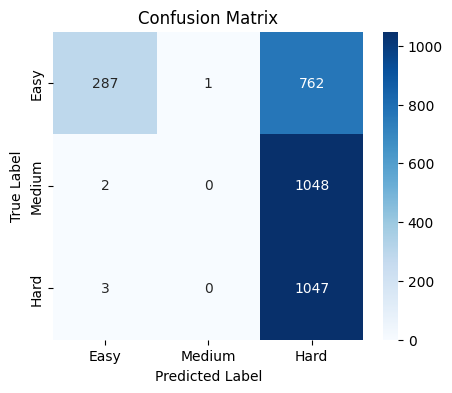

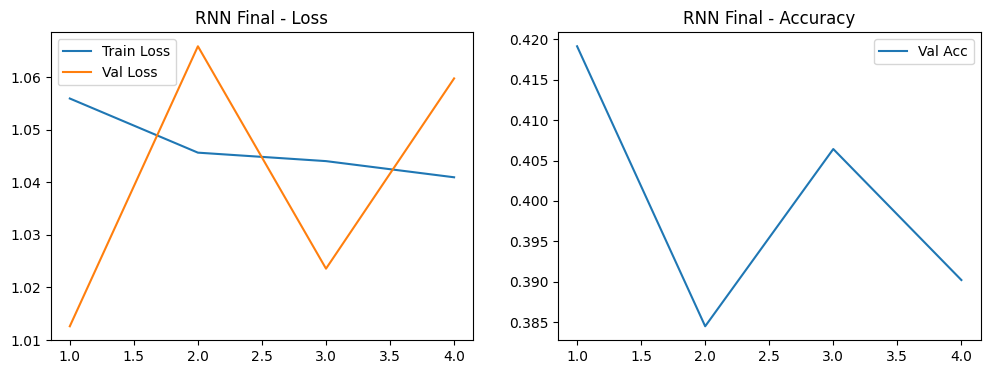


--- דוגמאות לטעות (Medium -> Hard) ---
1) who wrote the screenplay for director barbe schroeder's palme d'or winning movie

2) herieth paul is a tanzanian fashion model who has walked for an american fashion designer who directed what 2009 film

3) what year was the actor born that stared in a 1985 american comedy head office

4) piano concerto was premiered by a pianist who has what ethnicity

5) what primarily competed with nintendo 64 and sega staurn has a horror themed adventure game published by jaleco in 1999



In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.0
LEARNING_RATE = 0.001
BATCH_SIZE = 32           # <--- הנה הוא! נסי 32, 64 או 128
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = True          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    #embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    #is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

--- מריץ ניסוי: RNN | BS=64 | Frozen=True ---
Epoch 1/10 | Val Loss: 1.0325 | Val Acc: 0.4074
Epoch 2/10 | Val Loss: 0.9819 | Val Acc: 0.4570
Epoch 3/10 | Val Loss: 0.9851 | Val Acc: 0.4510
Epoch 4/10 | Val Loss: 0.9804 | Val Acc: 0.4526
Epoch 5/10 | Val Loss: 0.9748 | Val Acc: 0.4558
Epoch 6/10 | Val Loss: 0.9694 | Val Acc: 0.4637
Epoch 7/10 | Val Loss: 0.9903 | Val Acc: 0.4548
Epoch 8/10 | Val Loss: 0.9782 | Val Acc: 0.4545
Epoch 9/10 | Val Loss: 0.9712 | Val Acc: 0.4618
Early stopping at epoch 9

              precision    recall  f1-score   support

        Easy       0.74      0.44      0.55      1050
      Medium       0.35      0.04      0.07      1050
        Hard       0.38      0.88      0.53      1050

    accuracy                           0.45      3150
   macro avg       0.49      0.45      0.38      3150
weighted avg       0.49      0.45      0.38      3150



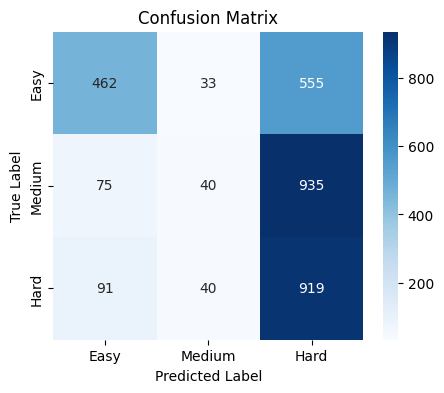

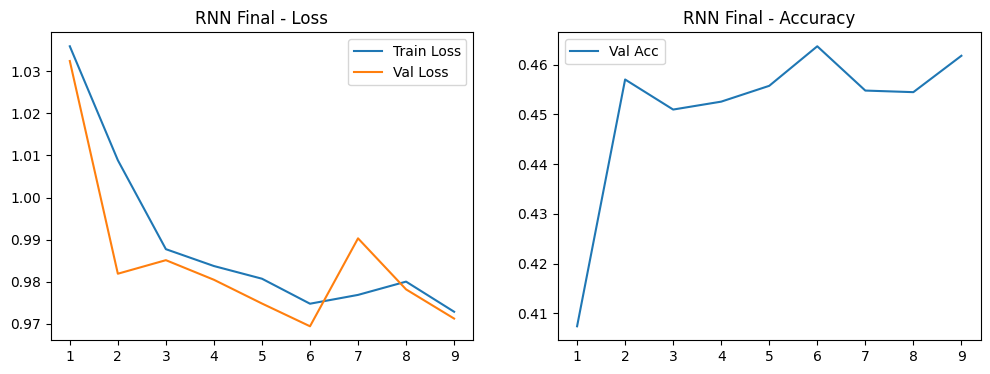


--- דוגמאות לטעות (Medium -> Hard) ---
1) who wrote the screenplay for director barbe schroeder's palme d'or winning movie

2) herieth paul is a tanzanian fashion model who has walked for an american fashion designer who directed what 2009 film

3) what year was the actor born that stared in a 1985 american comedy head office

4) piano concerto was premiered by a pianist who has what ethnicity

5) what primarily competed with nintendo 64 and sega staurn has a horror themed adventure game published by jaleco in 1999



In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.2
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 3
PATIENCE = 3
IS_FROZEN = True          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    #embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    #is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

/tmp/ipython-input-2433062993.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


--- מריץ ניסוי: RNN | BS=32 | Frozen=True ---
Epoch 1/10 | Val Loss: 0.9861 | Val Acc: 0.4586
Epoch 2/10 | Val Loss: 1.0604 | Val Acc: 0.4017
Epoch 3/10 | Val Loss: 0.9879 | Val Acc: 0.4459
Epoch 4/10 | Val Loss: 0.9787 | Val Acc: 0.4554
Epoch 5/10 | Val Loss: 1.0774 | Val Acc: 0.3740
Epoch 6/10 | Val Loss: 1.0182 | Val Acc: 0.4157
Epoch 7/10 | Val Loss: 1.0013 | Val Acc: 0.4354
Early stopping at epoch 7

              precision    recall  f1-score   support

        Easy       0.81      0.40      0.54      1050
      Medium       0.38      0.96      0.55      1050
        Hard       0.00      0.00      0.00      1050

    accuracy                           0.45      3150
   macro avg       0.40      0.45      0.36      3150
weighted avg       0.40      0.45      0.36      3150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


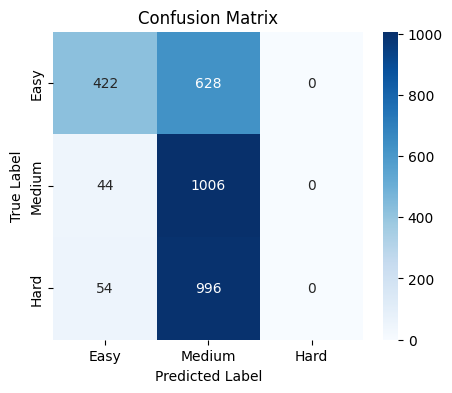

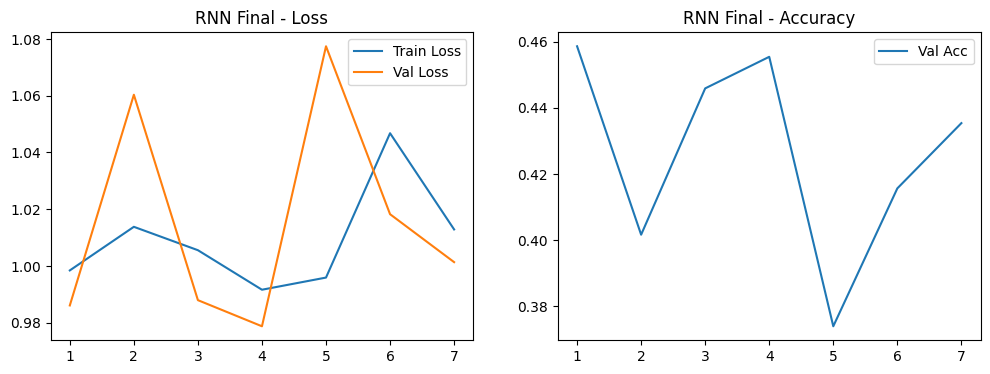


--- דוגמאות לטעות (Medium -> Hard) ---


In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.0
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = True          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

/tmp/ipython-input-2433062993.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


--- מריץ ניסוי: RNN | BS=32 | Frozen=False ---
Epoch 1/10 | Val Loss: 0.9881 | Val Acc: 0.4580
Epoch 2/10 | Val Loss: 0.9755 | Val Acc: 0.4567
Epoch 3/10 | Val Loss: 1.0203 | Val Acc: 0.4293
Epoch 4/10 | Val Loss: 0.9853 | Val Acc: 0.4545
Epoch 5/10 | Val Loss: 1.0552 | Val Acc: 0.3857
Early stopping at epoch 5

              precision    recall  f1-score   support

        Easy       0.76      0.44      0.56      1050
      Medium       0.00      0.00      0.00      1050
        Hard       0.38      0.93      0.54      1050

    accuracy                           0.45      3150
   macro avg       0.38      0.45      0.37      3150
weighted avg       0.38      0.45      0.37      3150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


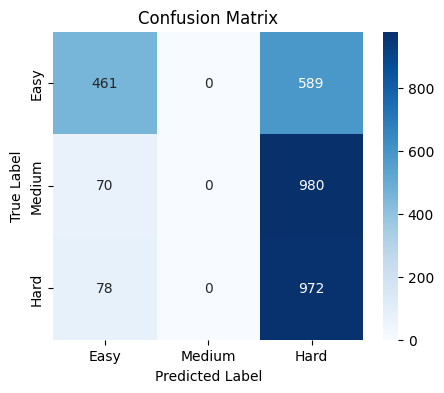

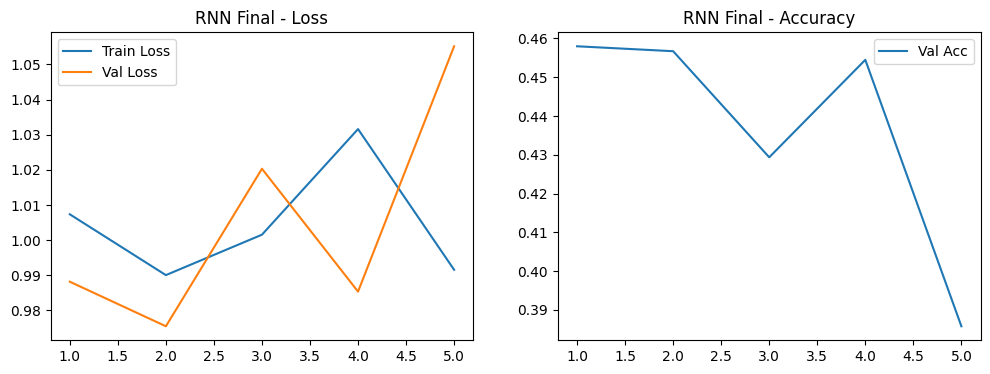


--- דוגמאות לטעות (Medium -> Hard) ---
1) who wrote the screenplay for director barbe schroeder's palme d'or winning movie

2) herieth paul is a tanzanian fashion model who has walked for an american fashion designer who directed what 2009 film

3) what year was the actor born that stared in a 1985 american comedy head office

4) piano concerto was premiered by a pianist who has what ethnicity

5) what primarily competed with nintendo 64 and sega staurn has a horror themed adventure game published by jaleco in 1999



In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.0
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = False          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

/tmp/ipython-input-2433062993.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


--- מריץ ניסוי: RNN | BS=32 | Frozen=False ---
Epoch 1/10 | Val Loss: 1.0159 | Val Acc: 0.4583
Epoch 2/10 | Val Loss: 1.0084 | Val Acc: 0.4402
Epoch 3/10 | Val Loss: 1.0070 | Val Acc: 0.4589
Epoch 4/10 | Val Loss: 1.0671 | Val Acc: 0.4211
Epoch 5/10 | Val Loss: 1.0001 | Val Acc: 0.4300
Epoch 6/10 | Val Loss: 0.9862 | Val Acc: 0.4577
Epoch 7/10 | Val Loss: 0.9782 | Val Acc: 0.4574
Epoch 8/10 | Val Loss: 1.0102 | Val Acc: 0.4484
Epoch 9/10 | Val Loss: 0.9802 | Val Acc: 0.4551
Epoch 10/10 | Val Loss: 0.9905 | Val Acc: 0.4593
Early stopping at epoch 10

              precision    recall  f1-score   support

        Easy       0.74      0.43      0.55      1050
      Medium       0.39      0.93      0.55      1050
        Hard       0.00      0.00      0.00      1050

    accuracy                           0.46      3150
   macro avg       0.38      0.46      0.36      3150
weighted avg       0.38      0.46      0.36      3150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


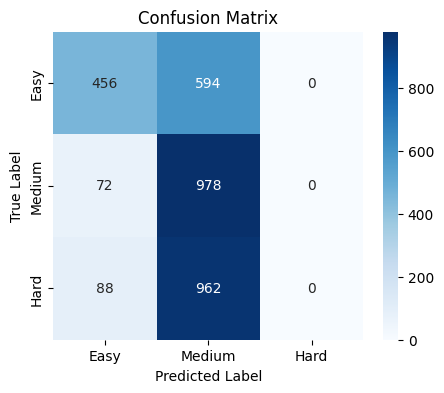

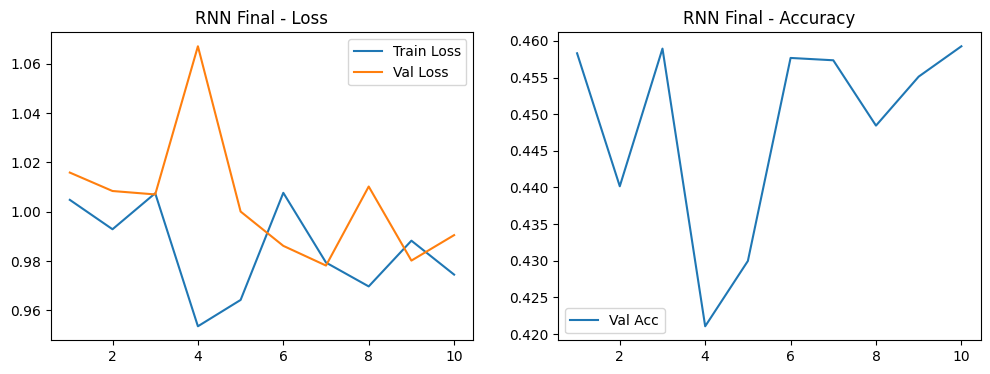


--- דוגמאות לטעות (Medium -> Hard) ---


In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.2
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = False          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

/tmp/ipython-input-2433062993.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


--- מריץ ניסוי: RNN | BS=32 | Frozen=False ---
Epoch 1/10 | Val Loss: 1.0196 | Val Acc: 0.4150
Epoch 2/10 | Val Loss: 1.0306 | Val Acc: 0.4519
Epoch 3/10 | Val Loss: 0.9898 | Val Acc: 0.4472
Epoch 4/10 | Val Loss: 0.9805 | Val Acc: 0.4554
Epoch 5/10 | Val Loss: 1.0087 | Val Acc: 0.4319
Epoch 6/10 | Val Loss: 0.9778 | Val Acc: 0.4564
Epoch 7/10 | Val Loss: 0.9800 | Val Acc: 0.4561
Epoch 8/10 | Val Loss: 0.9643 | Val Acc: 0.4647
Epoch 9/10 | Val Loss: 0.9966 | Val Acc: 0.4516
Epoch 10/10 | Val Loss: 1.0060 | Val Acc: 0.4723

              precision    recall  f1-score   support

        Easy       0.76      0.43      0.55      1050
      Medium       0.42      0.53      0.47      1050
        Hard       0.37      0.43      0.40      1050

    accuracy                           0.46      3150
   macro avg       0.52      0.46      0.47      3150
weighted avg       0.52      0.46      0.47      3150



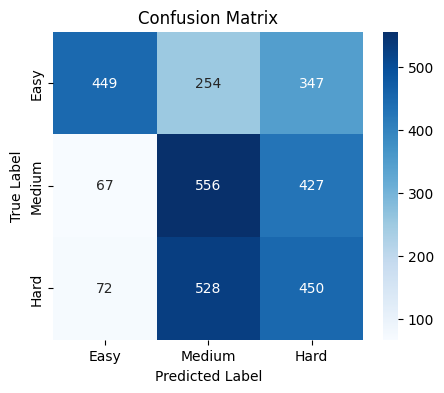

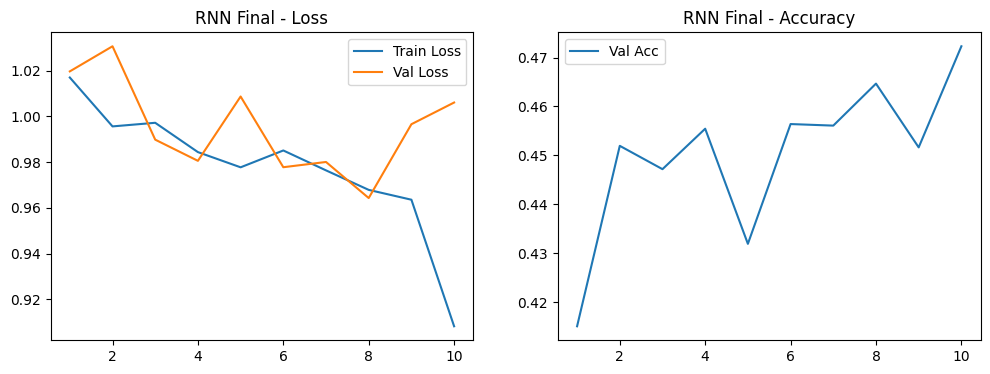


--- דוגמאות לטעות (Medium -> Hard) ---
1) who wrote the screenplay for director barbe schroeder's palme d'or winning movie

2) piano concerto was premiered by a pianist who has what ethnicity

3) simone simeri plays for the italian team from what state

4) who is older wang shuang or lionel messi

5) in which movie did olivia thirlby play the part of pregnant teen ellen page



In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.3
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = False          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

/tmp/ipython-input-2433062993.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


--- מריץ ניסוי: RNN | BS=32 | Frozen=False ---
Epoch 1/8 | Val Loss: 0.9737 | Val Acc: 0.4551
Epoch 2/8 | Val Loss: 1.0451 | Val Acc: 0.3940
Epoch 3/8 | Val Loss: 1.0348 | Val Acc: 0.4032
Epoch 4/8 | Val Loss: 0.9800 | Val Acc: 0.4561
Early stopping at epoch 4

              precision    recall  f1-score   support

        Easy       0.75      0.43      0.55      1050
      Medium       0.42      0.29      0.34      1050
        Hard       0.38      0.66      0.49      1050

    accuracy                           0.46      3150
   macro avg       0.52      0.46      0.46      3150
weighted avg       0.52      0.46      0.46      3150



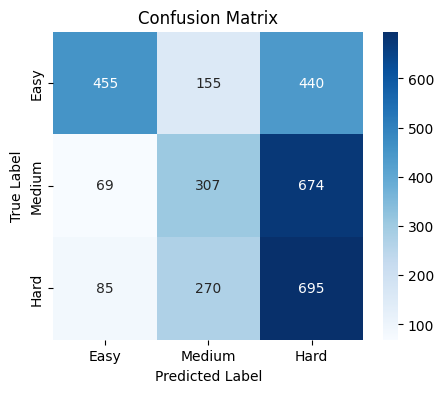

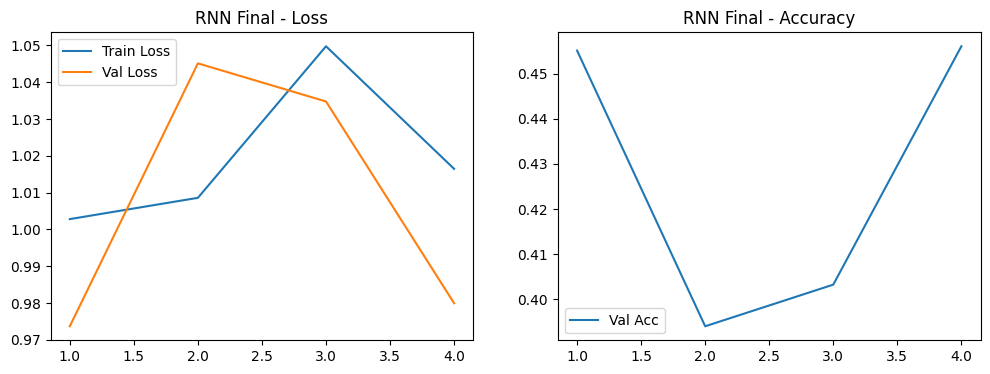


--- דוגמאות לטעות (Medium -> Hard) ---
1) who wrote the screenplay for director barbe schroeder's palme d'or winning movie

2) what year was the actor born that stared in a 1985 american comedy head office

3) piano concerto was premiered by a pianist who has what ethnicity

4) simone simeri plays for the italian team from what state

5) who is older wang shuang or lionel messi



In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.3
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 8
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = False          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)